In [3]:
from load import load_all_sis_data
import numpy as np

# Load all data
all_flux_data, datetime_values, element_mapping = load_all_sis_data('flux_1998/')

print("All data shape:", all_flux_data.shape)
print("Element Mapping:", element_mapping, "\n")

# Precompute the Q1 values for each element
energy_level_to_compute = 1
q1_values = {}
for element_name, element_index in element_mapping.items():
    valid_data_mask = (all_flux_data[energy_level_to_compute - 1, :, element_index] != -999.9) & (all_flux_data[energy_level_to_compute - 1, :, element_index] != 0)
    element_flux_for_stats = all_flux_data[energy_level_to_compute - 1, :, element_index][valid_data_mask]
    if len(element_flux_for_stats) > 0:
        q1_values[element_name] = np.percentile(element_flux_for_stats, 25)

# multiplier for He and O to account for abundance
q1_values["He"] *= 3
q1_values["O"] *= 2.25
print("Q1 Cutoffs: ", q1_values)

# These values will be used as the lower cutoff for decay event identification
he_flux_threshold = q1_values["He"]

All data shape: (8, 140280, 6)
Element Mapping: {'C': 0, 'Fe': 1, 'He': 2, 'N': 3, 'O': 4, 'Si': 5} 

Q1 Cutoffs:  {'C': 4.1736e-06, 'Fe': 1.6871e-06, 'He': 0.00010935, 'N': 3.4857e-06, 'O': 7.243424999999999e-06, 'Si': 2.3564e-06}


In [4]:
import pandas as pd
from identification import compute_decay_events_for_all_data

# Define parameters for decay detection and event counting
energy_level_to_compute = 1
min_duration_hours = 48
window_size = 24  # hours for detecting decays in He flux
window_size_for_decay_count = 18  # hours for counting decaying elements
slope_threshold = -0.005
r_value_threshold = 0.0

# Compute decay events with the new parameters
decay_events_df = compute_decay_events_for_all_data(all_flux_data, datetime_values, element_mapping, energy_level_to_compute, he_flux_threshold, min_duration_hours, window_size, window_size_for_decay_count, slope_threshold, r_value_threshold)

# Fix columns from wrapping
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

print(decay_events_df)


     Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour   Elements Decaying Non-Decaying Elements
0           1         1998       1998          26.791655            30.291655       18.999722   6.999722          1            [Si, Fe, N, C, O] 
1           8         1998       1998         100.250000           105.374988        6.000000   8.999722          1            [Si, Fe, N, C, O] 
2           9         1998       1998         105.458322           109.375000       10.999722   9.000000          1            [Si, Fe, N, C, O] 
3          10         1998       1998         112.000000           118.624988        0.000000  14.999722          6                           [] 
4          11         1998       1998         120.124988           129.291667        2.999722   7.000000          6                           [] 
..            ...         ...       ...                   ...                 ...         ...        ...                ... 

Next, we filter by events that have at least 4/6 elements decaying or more

In [6]:
def filter_by_elements_decaying(decay_events_df, min_elements_decaying_list):
    # Filter the DataFrame based on any of the minimum thresholds
    filtered_df = decay_events_df[decay_events_df['Elements Decaying'].isin(min_elements_decaying_list)]

    # Reset the index of the filtered DataFrame
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

min_elements_decaying_list = [4, 5, 6]  # Set the thresholds for elements decaying
filtered_df = filter_by_elements_decaying(decay_events_df, min_elements_decaying_list)

print(filtered_df)

from graph import plot_all_decay_events

energy_level_to_plot = 1
extend_days = 2  # Adjust the number of days to extend before and after
print(f"Graph of flux events using data from energy level {energy_level_to_plot} and using data from Helium at energy level {energy_level_to_compute} for cutoffs")
#plot_all_decay_events(filtered_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days, True)


     Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour   Elements Decaying Non-Decaying Elements
0          10         1998       1998         112.000000           118.624988        0.000000  14.999722          6                      []      
1          11         1998       1998         120.124988           129.291667        2.999722   7.000000          6                      []      
2          12         1998       1998         129.624988           136.125000       14.999722   3.000000          6                      []      
3          21         1998       1998         168.833322           173.374988       19.999722   8.999722          4                [Si, Fe]      
4          37         1998       1998         237.874988           244.666667       20.999722  16.000000          6                      []      
..            ...         ...       ...                   ...                 ...         ...        ...                ... 

Create dataframe of individual traces and drop the last column (target labels) so that we can use our model to insert predictions

In [7]:
import numpy as np
import pandas as pd
from features import create_dataframe

test_decay_df = create_dataframe(decay_events_df, datetime_values, all_flux_data, element_mapping, 0)
test_decay_df = test_decay_df.drop(test_decay_df.columns[-1], axis=1)

test_decay_df.to_csv("out_csv/decay_test_features_1998.csv", index=False)
print(test_decay_df)


c:\Users\jeffr\OneDrive\Documents\SURF2024\features.py:50: RuntimeWarning: Mean of empty slice
  avg_decay_percentages = np.nanmean(


      Event ID  Element  Duration  Max Flux  Initial Decay Rate  Average Decay Rate  Time to Peak  Peak Prominence  Number of Peaks  Skewness  Kurtosis     Std Flux    Median Flux  Normalized Time to Peak  Decay Rate 25%  Decay Rate 50%  Decay Rate 75%  Avg Decay Percentages
0          1       0        96     0.000008     0.000000e+00        0.000000e+00           7          0.000008             7         3.066694   9.153997  1.455463e-06   0.000000           0.072917           0.000000e+00    0.000000e+00    0.000000e+00       0.000000e+00     
1          1       0        96     0.000003     1.387500e-07        3.468750e-08           0          0.000003            11         2.143288   2.618143  1.044158e-06   0.000000           0.000000           1.387500e-07    6.937500e-08    4.625000e-08       8.479167e-08     
2          1       0        96     0.000004     0.000000e+00        0.000000e+00           9          0.000004             3         5.403978  27.263387  6.532405e-07   0.0

Load the saved model, preprocess the data, and run evaluations

In [54]:
import pandas as pd
import joblib

# Load the model and scaler from the joblib files
model_filename = 'mlp_model/model_best.joblib'
scaler_filename = 'mlp_model/scaler_best.joblib'
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

# Load the new dataset (assuming the same format as the original, without the target column)
new_data_file_path = 'transformed_data/decay_test_features_1998.csv'
new_df = pd.read_csv(new_data_file_path)

# Define the column name for Event ID (replace 'Event ID' if different)
event_id_col = 'Event ID'

# Preprocess the new data (handle any missing values, etc.)
new_df.fillna(0, inplace=True) 
print(new_df.shape)

# **Map Event ID to predictions using merge (assuming index is preserved)**
new_df_with_id = new_df.copy()  # Copy to avoid modifying original DataFrame
new_df_with_id['Event ID'] = new_df_with_id[event_id_col]  # Add Event ID column for predictions

# Ignore the Event ID column before scaling
ignored_cols = [event_id_col]
new_df_for_model = new_df_with_id.drop(columns=ignored_cols)  # New DataFrame for model

# Transform the new data using the loaded scaler
new_data_scaled = loaded_scaler.transform(new_df_for_model)

# Predict the target flag using the loaded model
new_predictions = loaded_model.predict(new_data_scaled)

# Add the predictions as a new column to the DataFrame with Event ID
new_df_with_id['Predicted Target'] = new_predictions

# Save the new DataFrame with predictions and Event ID to a new CSV file
output_file_path = 'transformed_data/decay_test_predictions.csv'
new_df_with_id.to_csv(output_file_path, index=False)

# Print the DataFrame with predictions (original DataFrame with predictions and Event ID)
print(new_df_with_id)


(8952, 18)
      Event ID  Element  Duration  Max Flux  Initial Decay Rate  Average Decay Rate  Time to Peak  Peak Prominence  Number of Peaks  Skewness  Kurtosis     Std Flux    Median Flux  Normalized Time to Peak  Decay Rate 25%  Decay Rate 50%  Decay Rate 75%  Avg Decay Percentages  Predicted Target
0          1       0        96     0.000008     0.000000e+00        0.000000e+00           7          0.000008             7         3.066694   9.153997  1.455463e-06   0.000000           0.072917           0.000000e+00    0.000000e+00    0.000000e+00       0.000000e+00               0       
1          1       0        96     0.000003     1.387500e-07        3.468750e-08           0          0.000003            11         2.143288   2.618143  1.044158e-06   0.000000           0.000000           1.387500e-07    6.937500e-08    4.625000e-08       8.479167e-08               0       
2          1       0        96     0.000004     0.000000e+00        0.000000e+00           9          0.000

Take out only the event, element, and predicted target columns for further processing

In [55]:
import pandas as pd
selected_df = new_df_with_id[['Event ID', 'Element', 'Predicted Target']]
print(selected_df)

      Event ID  Element  Predicted Target
0          1       0             0       
1          1       0             0       
2          1       0             0       
3          1       0             0       
4          1       1             0       
...        ...      ...               ...
8947     640       4             1       
8948     640       5             0       
8949     640       5             0       
8950     640       5             0       
8951     640       5             0       

[8952 rows x 3 columns]


Put the splitted traces back together into the original events, and count the number of targets flagged by the model for each event

In [56]:
import pandas as pd

# Element mapping
reverse_mapping = {v: k for k, v in element_mapping.items()}

# Add new columns to decay_events_df for each element
for element in element_mapping.keys():
    decay_events_df[f'Num Targets {element}'] = 0

# Iterate through selected_df to count the number of 1s for each element for each event ID
for event_id, element, target in selected_df.values:
    element_name = reverse_mapping[element]
    if target == 1:
        decay_events_df.loc[decay_events_df['Event Number'] == event_id, f'Num Targets {element_name}'] += 1

# Display the updated decay_events_df
print(decay_events_df)


     Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour   Elements Decaying Non-Decaying Elements  Num Targets C  Num Targets Fe  Num Targets He  Num Targets N  Num Targets O  Num Targets Si
0           1         1998       1998          26.791655            30.291655       18.999722   6.999722          1            [N, O, Fe, Si, C]         0               0               1              0              4               0      
1           8         1998       1998         100.250000           105.374988        6.000000   8.999722          1            [N, O, Fe, Si, C]         3               0               0              2              4               0      
2           9         1998       1998         105.458322           109.375000       10.999722   9.000000          1            [N, O, Fe, Si, C]         0               0               0              0              3               0      
3          10         1998       1998       

Sort the events from most target identifications to least, with higher priority for heavier elements.

In [57]:
from IPython.display import display, HTML

# Create temp column for totals
decay_events_df['Total Targets'] = decay_events_df.iloc[:, 9:].sum(axis=1)
priority_order = ['Num Targets Fe', 'Num Targets Si', 'Num Targets N', 'Num Targets C', 'Num Targets O', 'Num Targets He']

# Sort the DataFrame and drop temporary total
sorted_df = decay_events_df.sort_values(by=['Total Targets'] + priority_order, ascending=[False] + [False] * len(priority_order))
sorted_df = sorted_df.drop(columns=['Total Targets'])

print(sorted_df)
# Create a scrollable HTML table
# scrollable_table = f"""
# <div style="max-height: 400px; overflow-y: scroll; border: 1px solid black; padding: 10px;">
#     {sorted_df.to_html(index=False)}
# </div>
# """
# display(HTML(scrollable_table))


     Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour   Elements Decaying Non-Decaying Elements  Num Targets C  Num Targets Fe  Num Targets He  Num Targets N  Num Targets O  Num Targets Si
3          10         1998       1998         112.000000           118.624988        0.000000  14.999722          6                           []         4               4               4              4              4               4      
5          12         1998       1998         129.624988           136.125000       14.999722   3.000000          6                           []         4               4               4              4              4               4      
16         37         1998       1998         237.874988           244.666667       20.999722  16.000000          6                           []         4               4               4              4              4               4      
21         43         1998       1998       

Take the top 20 events from the sorted list and graph them (only 20 so the graphing function doesn't take ages)

    Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour   Elements Decaying Non-Decaying Elements  Num Targets C  Num Targets Fe  Num Targets He  Num Targets N  Num Targets O  Num Targets Si
0         10         1998       1998         112.000000           118.624988        0.000000  14.999722          6                        []            4               4               4              4              4               4      
1         12         1998       1998         129.624988           136.125000       14.999722   3.000000          6                        []            4               4               4              4              4               4      
2         37         1998       1998         237.874988           244.666667       20.999722  16.000000          6                        []            4               4               4              4              4               4      
3         43         1998       1998         273

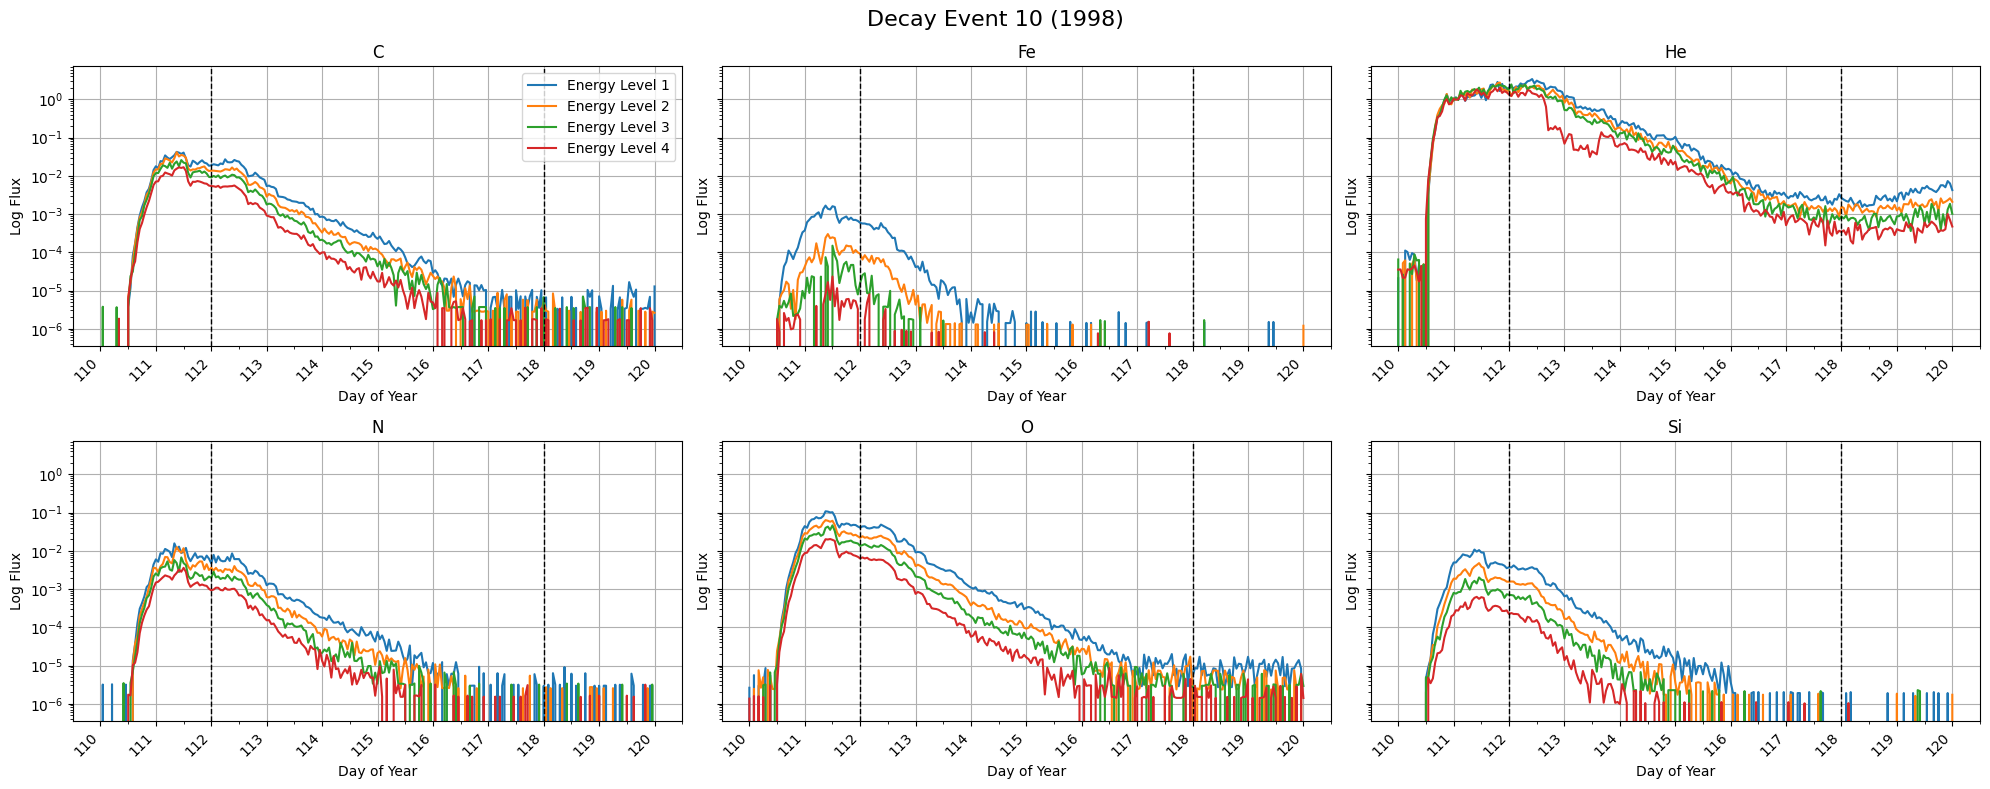

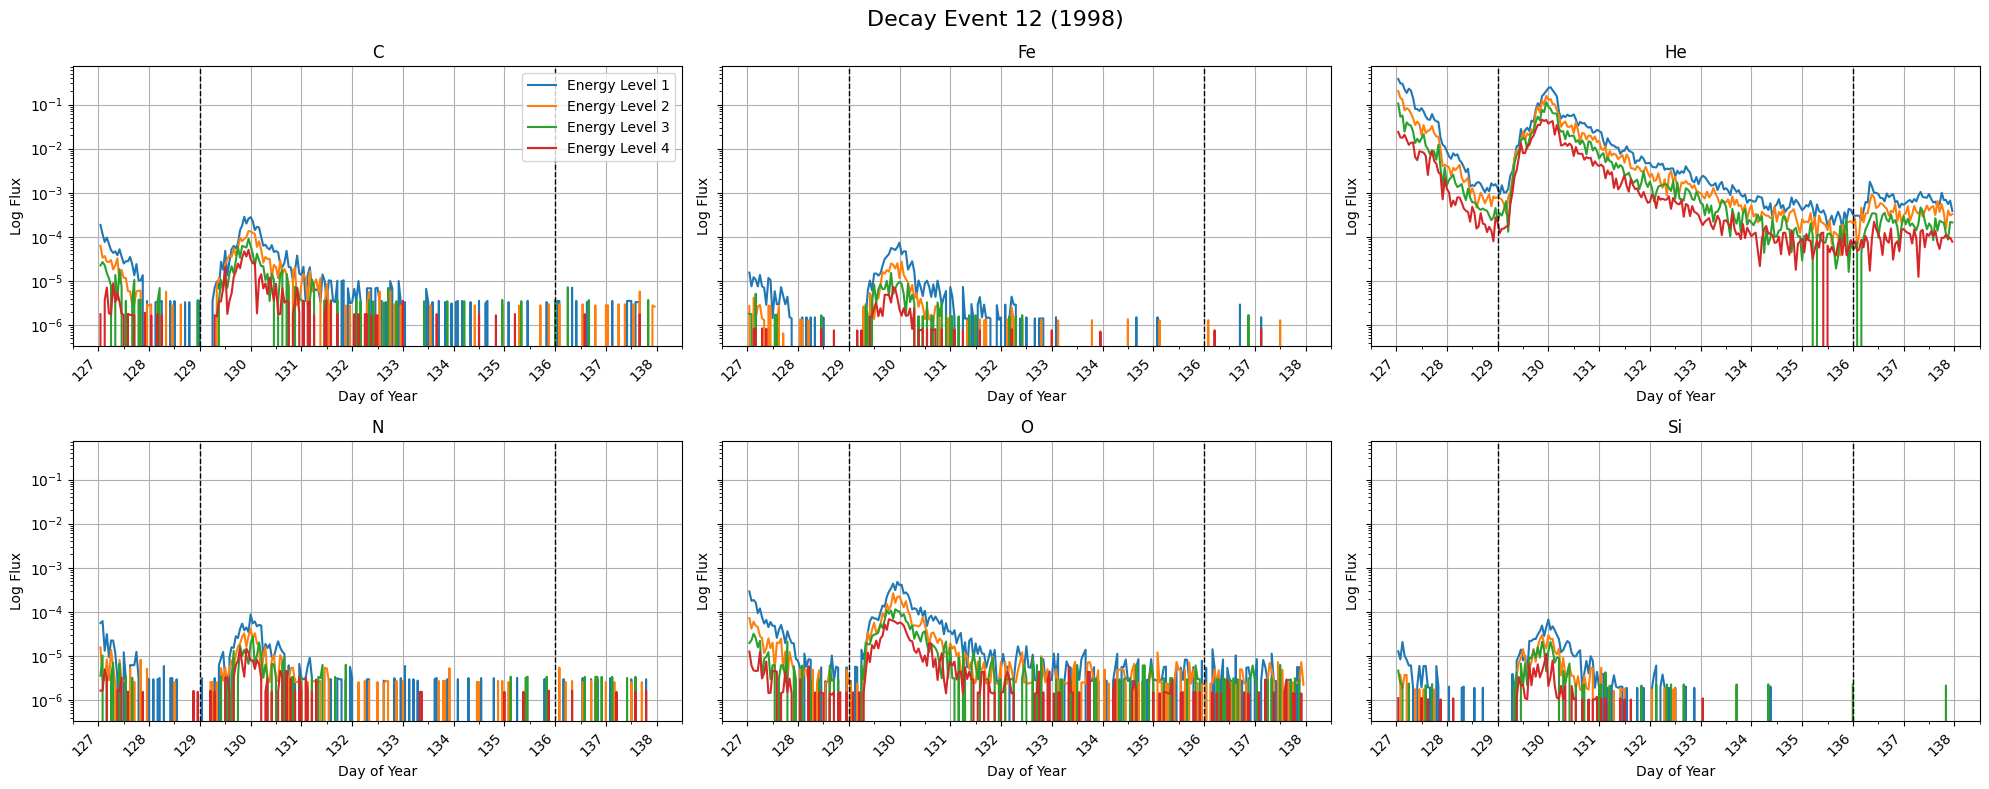

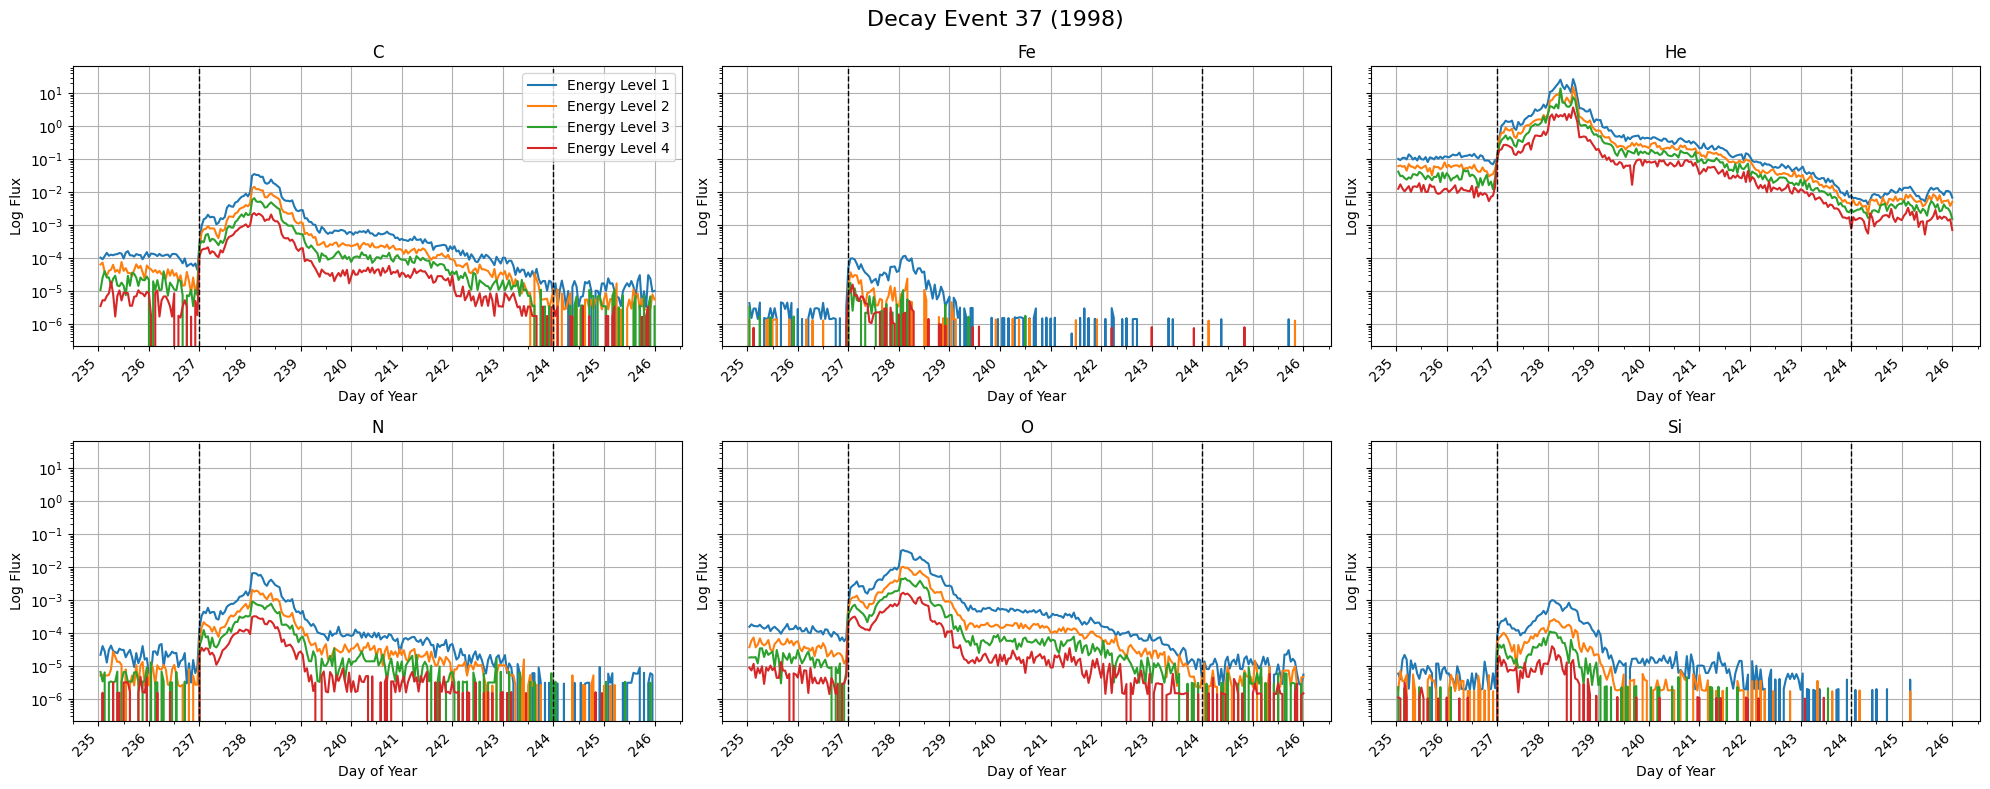

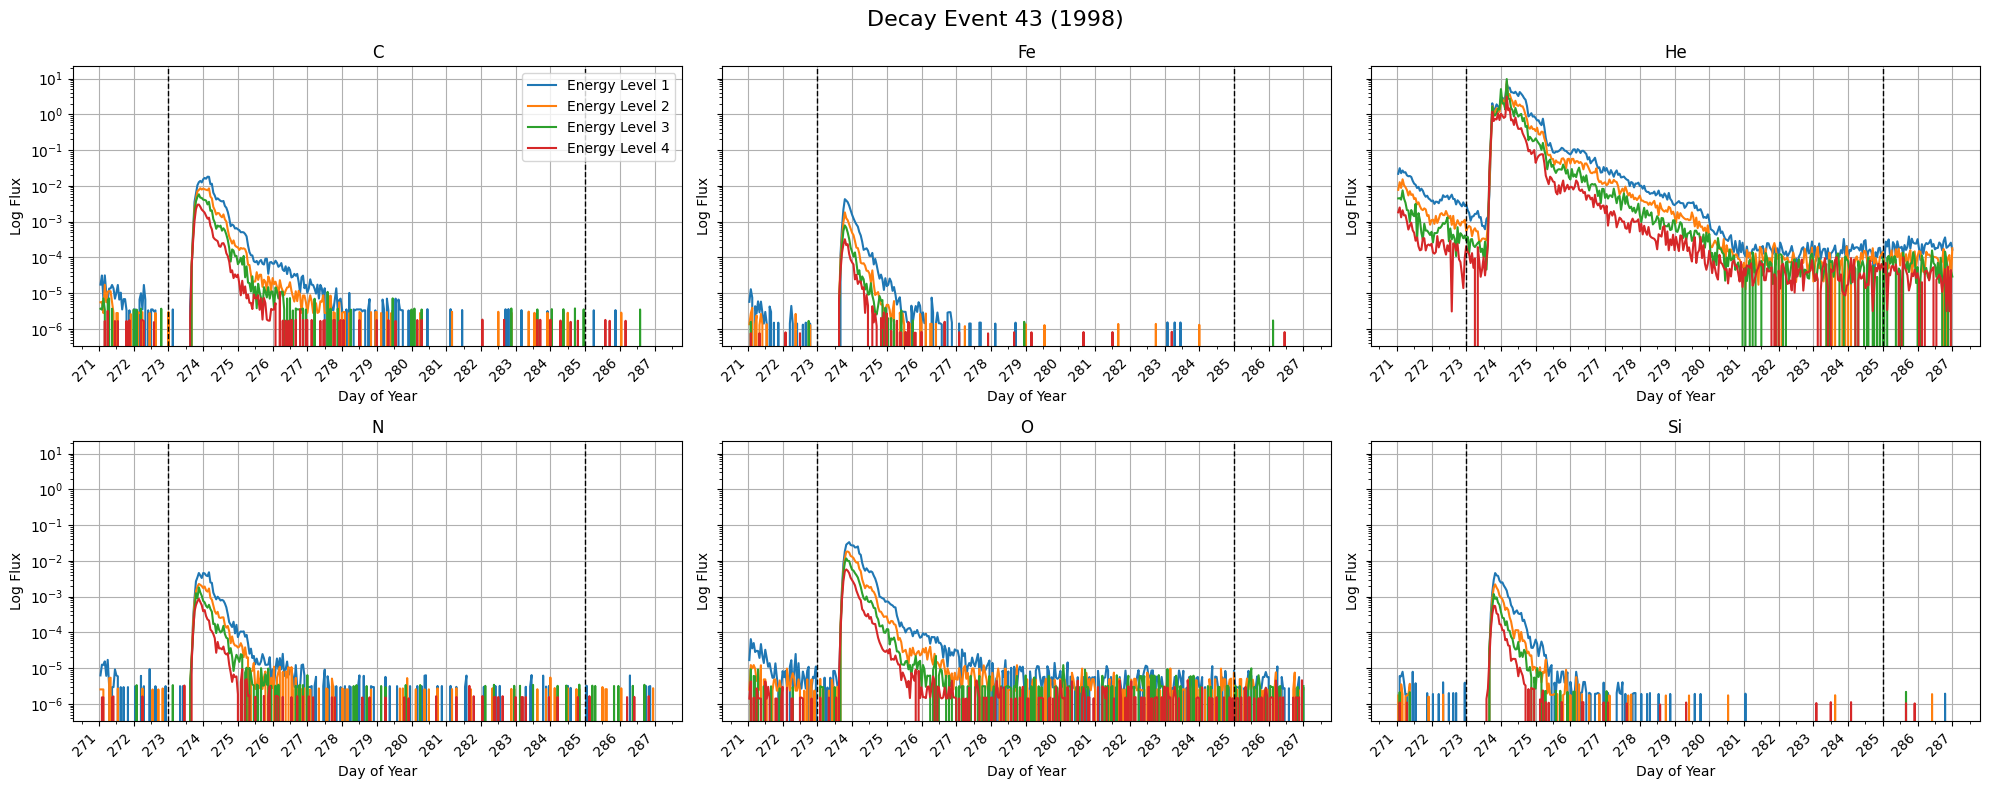

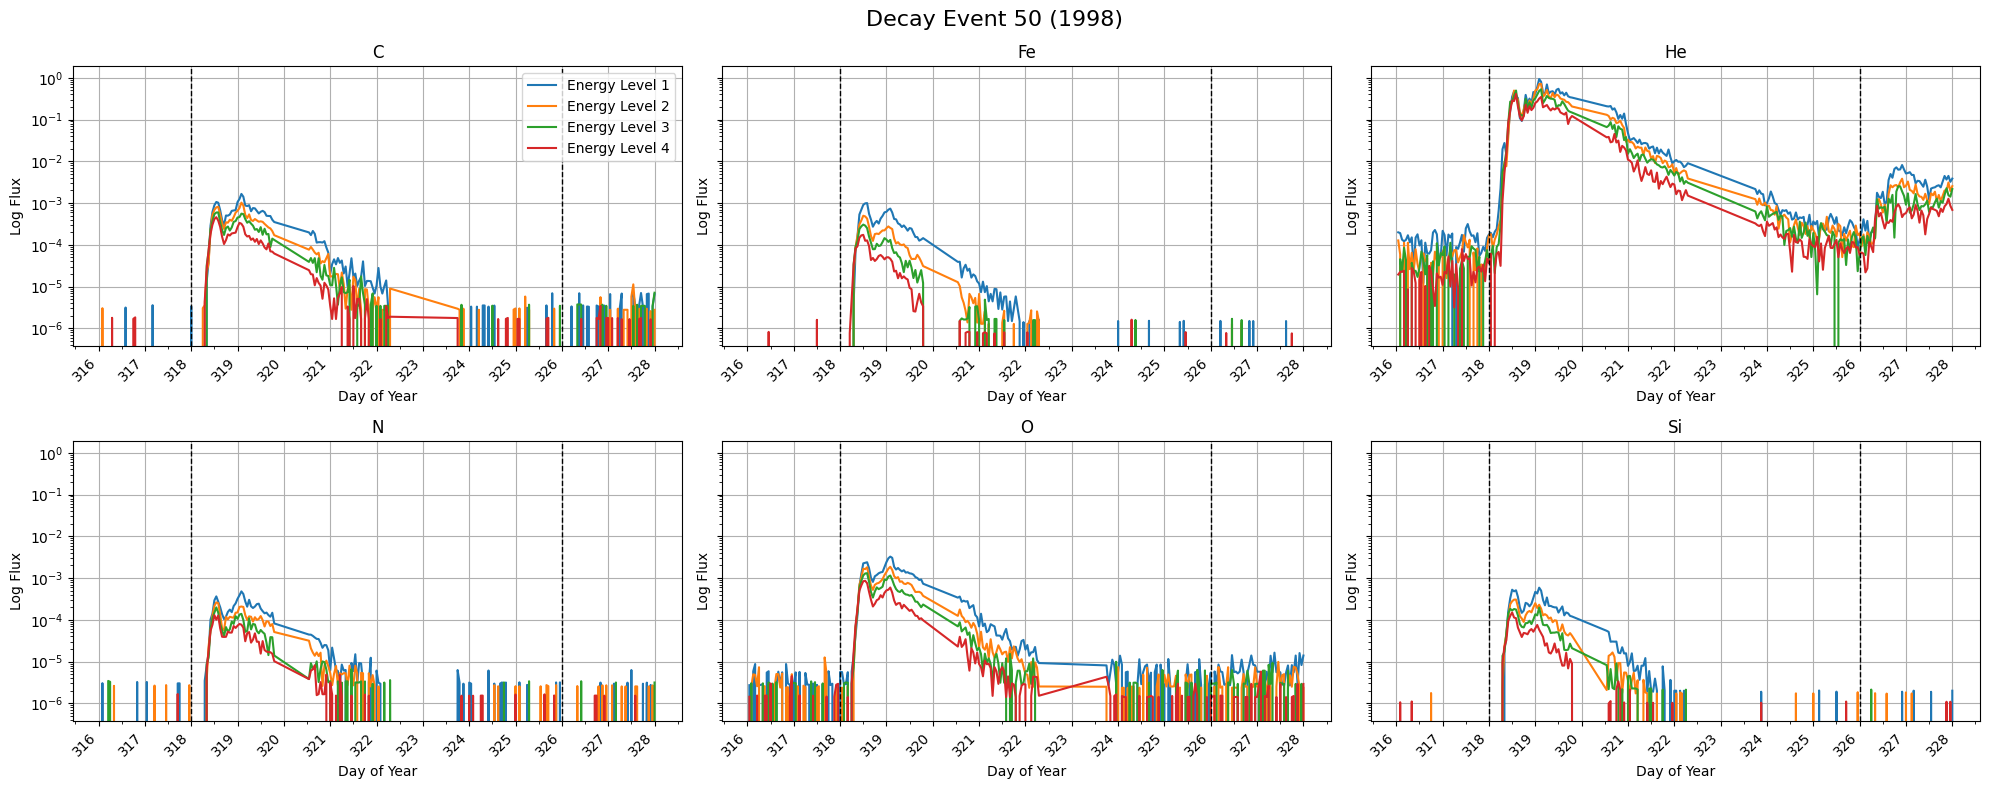

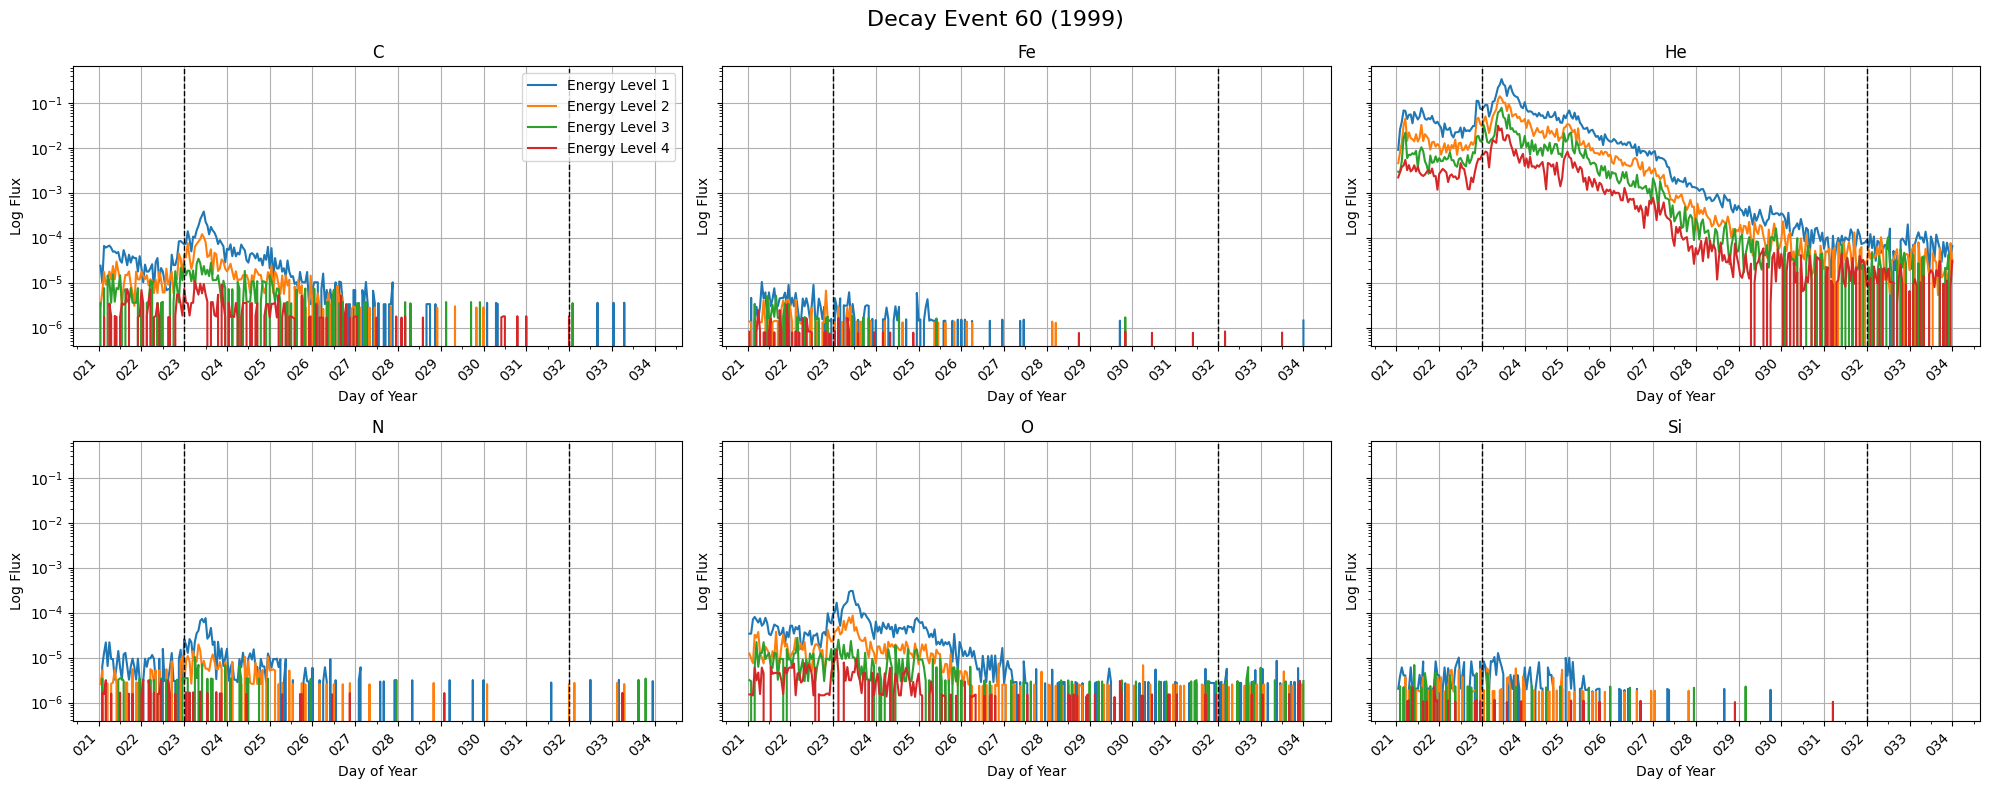

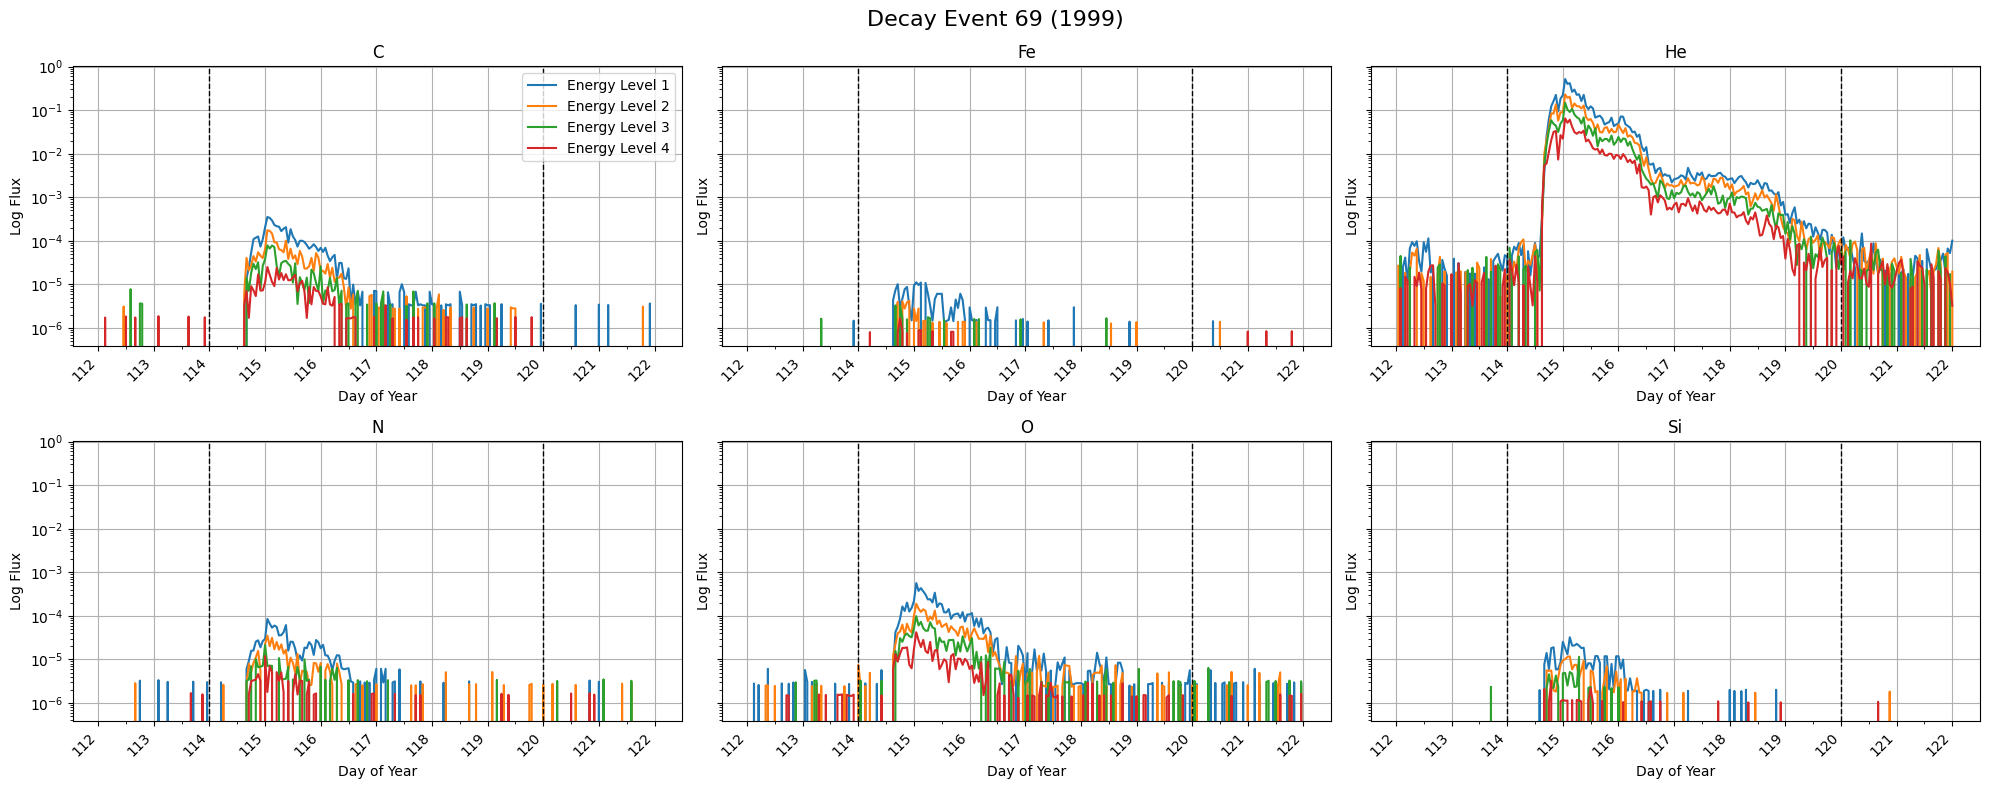

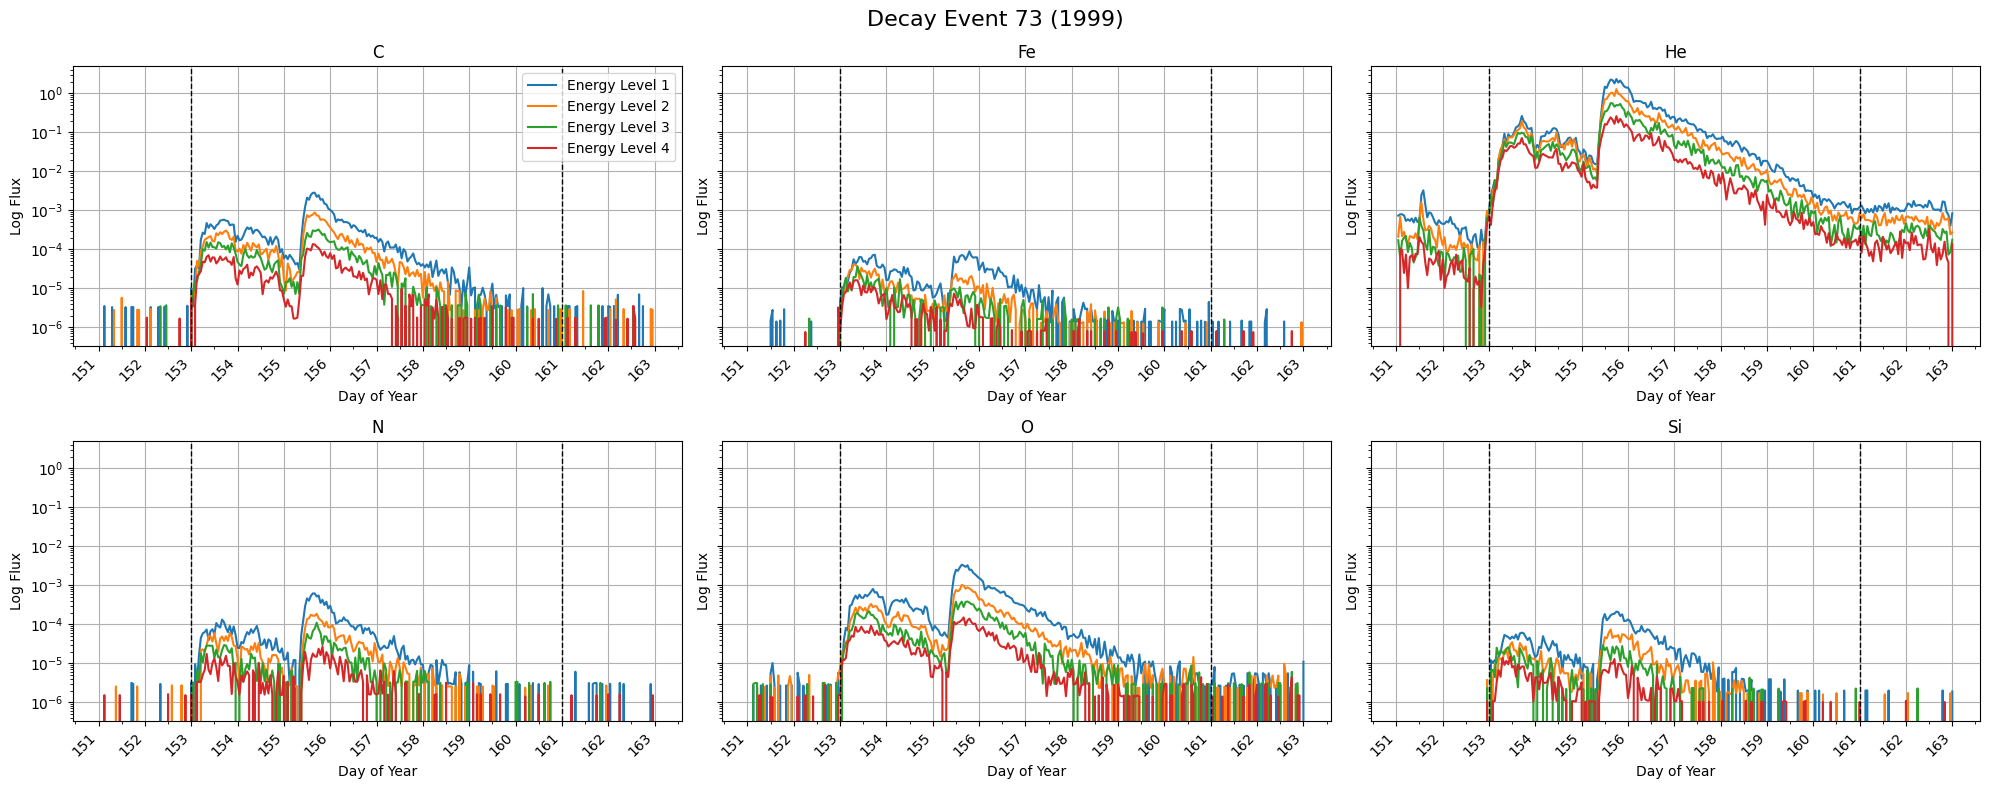

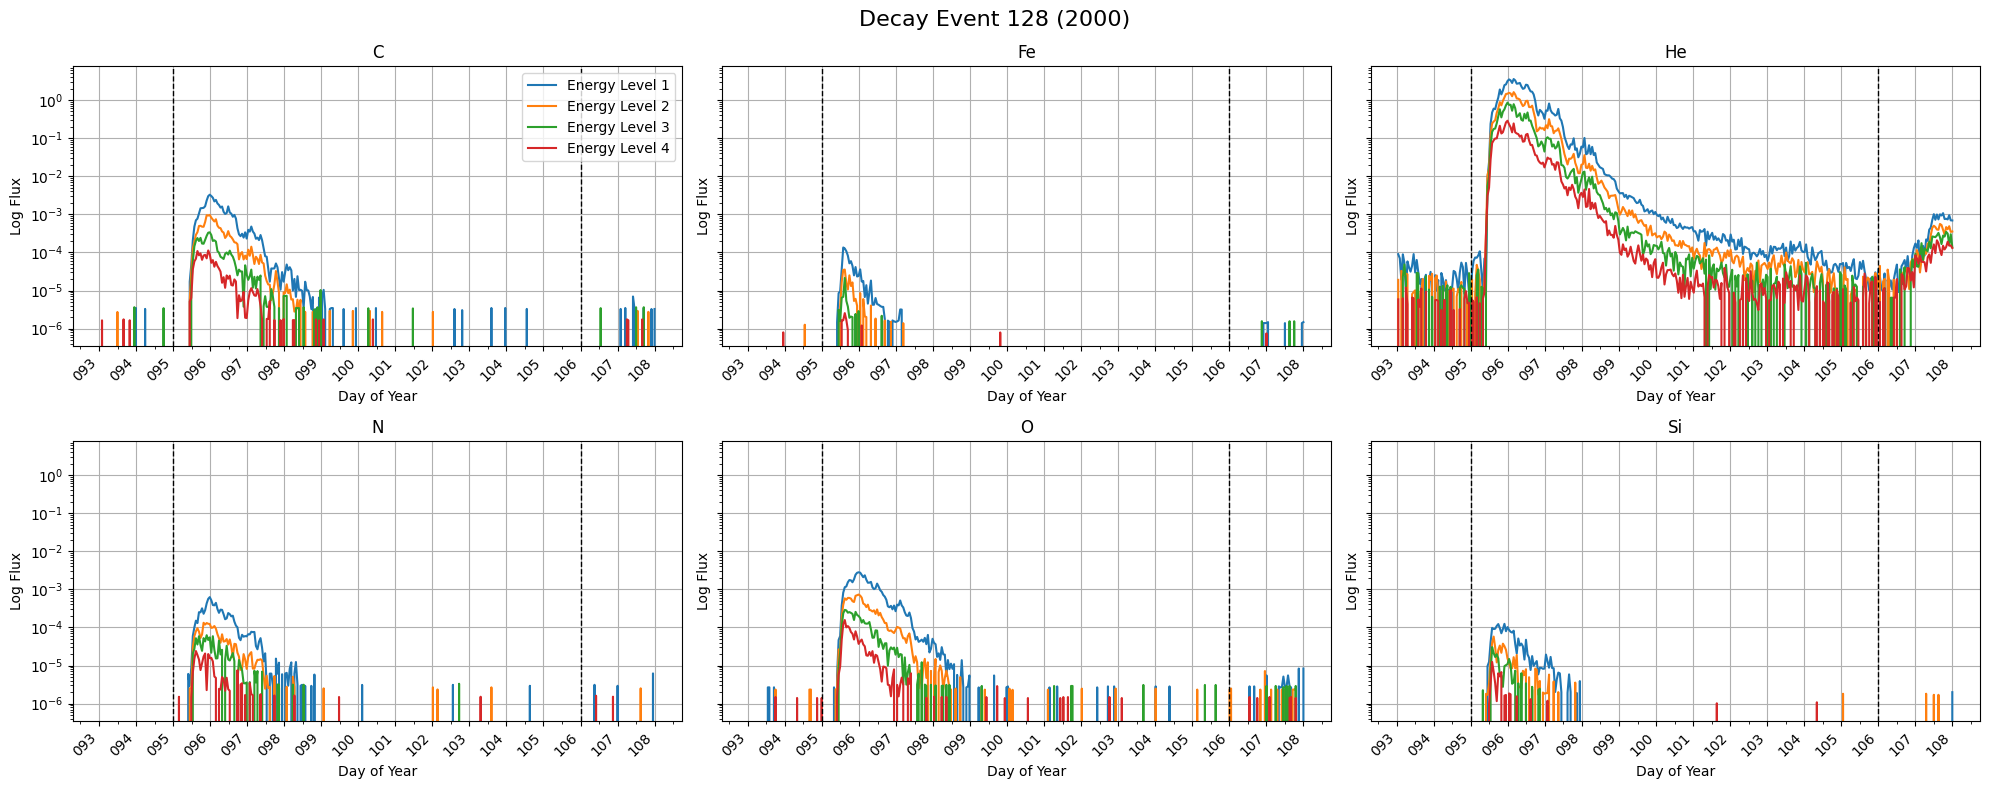

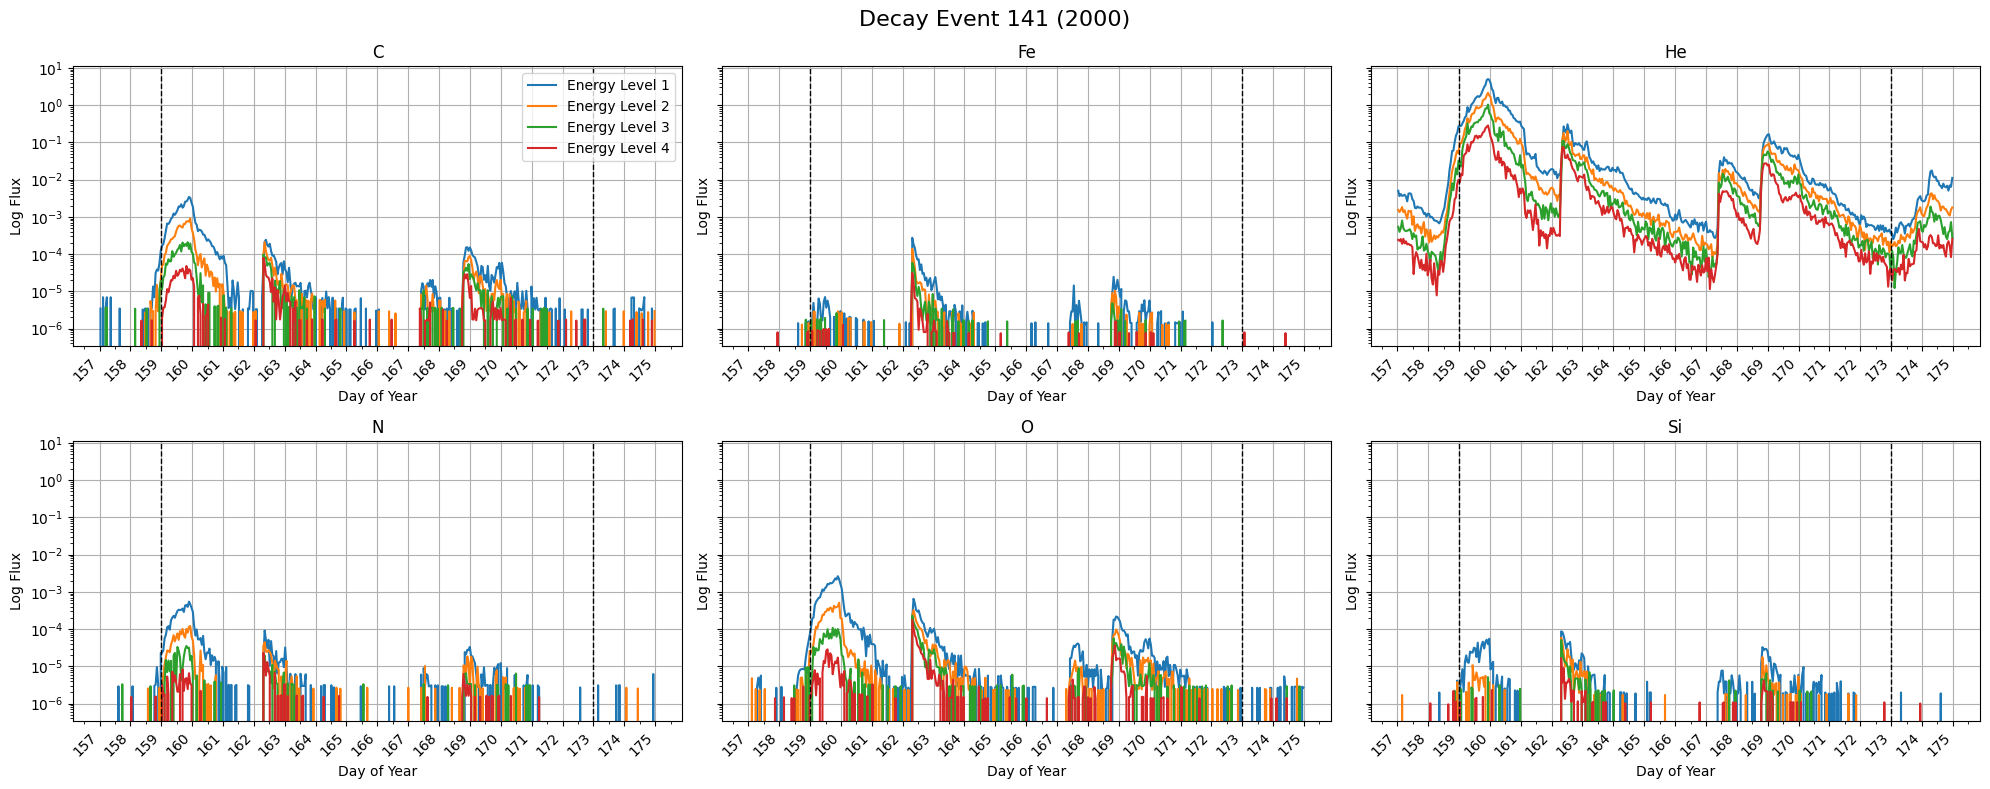

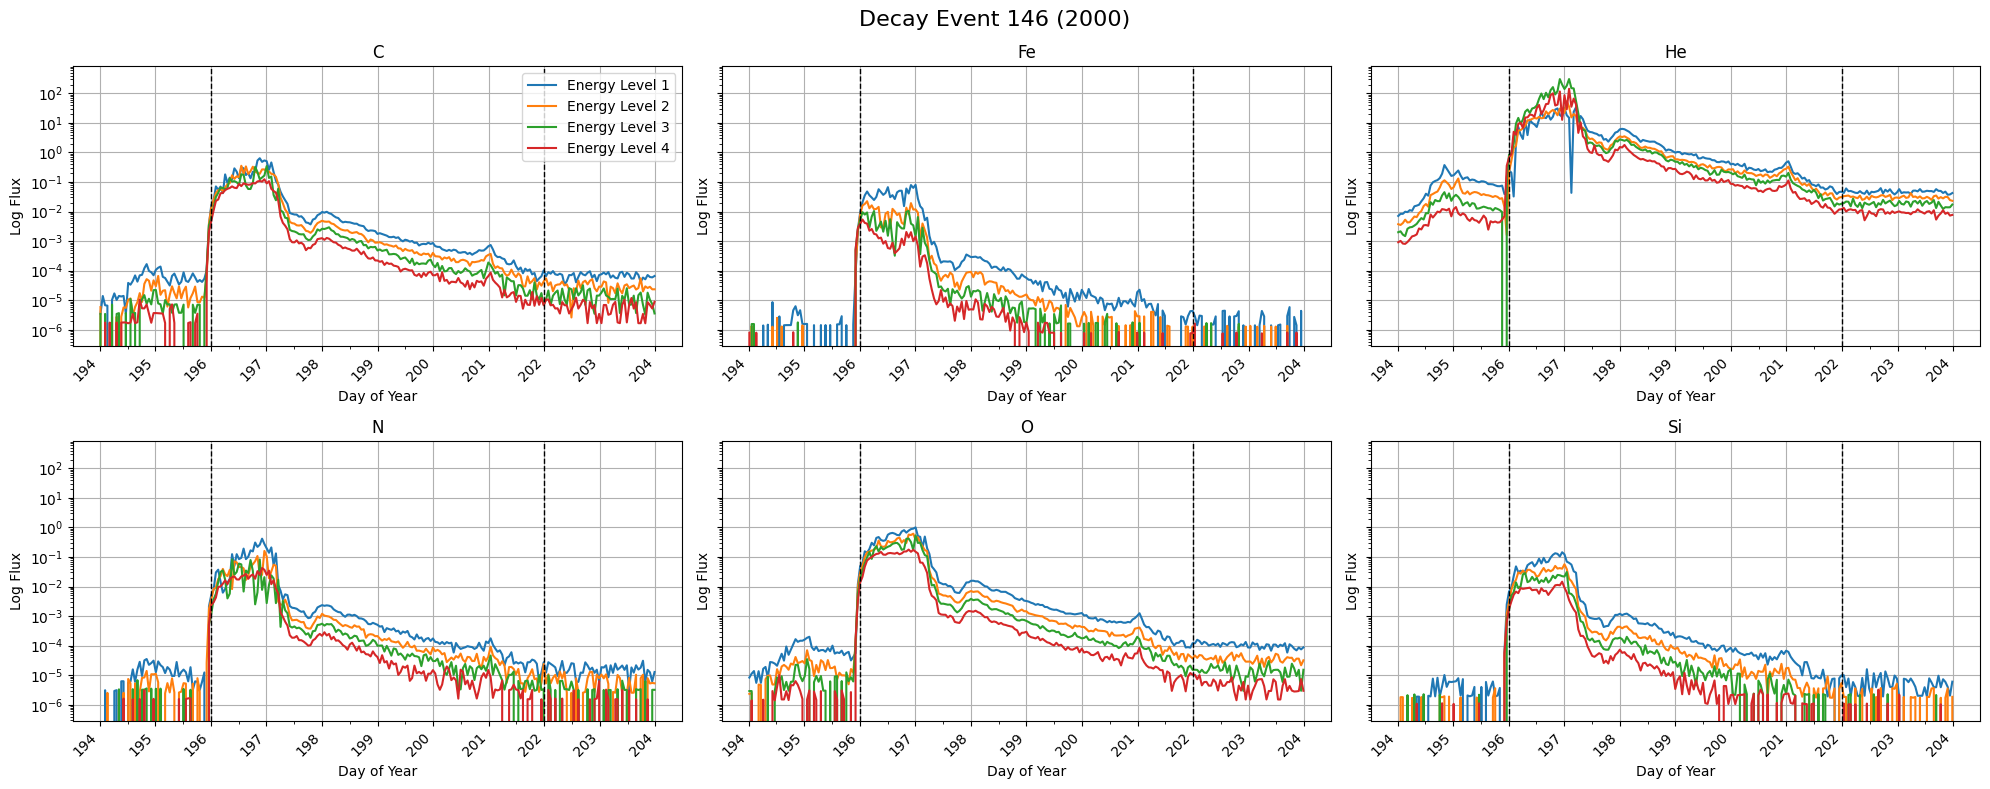

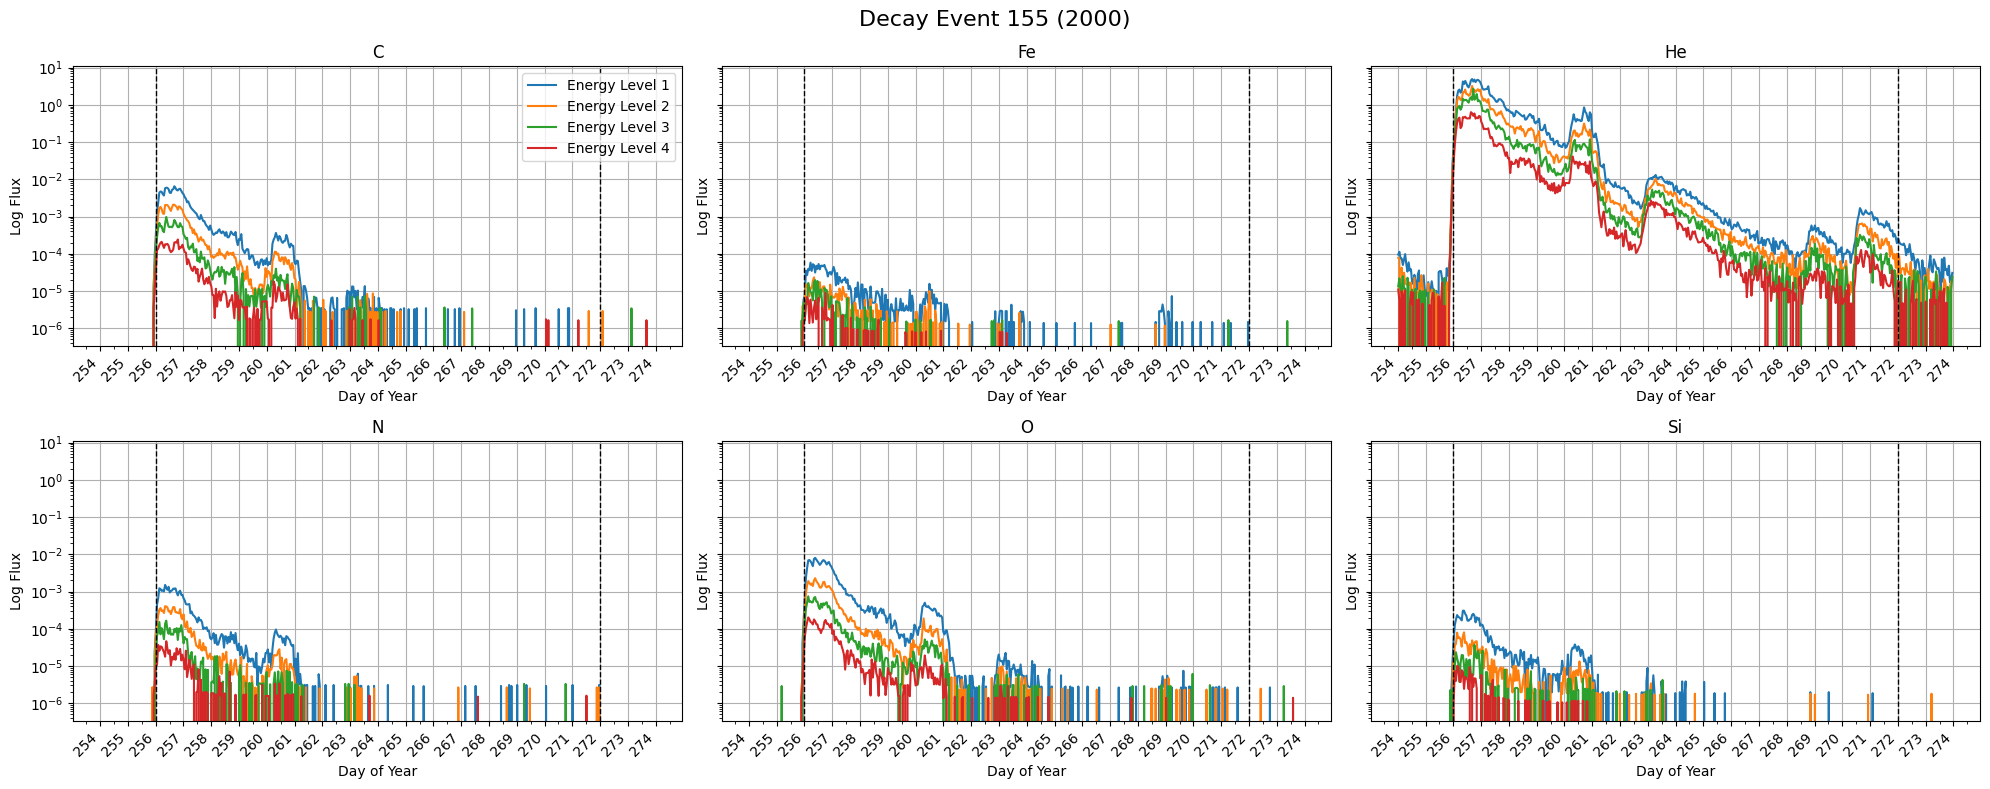

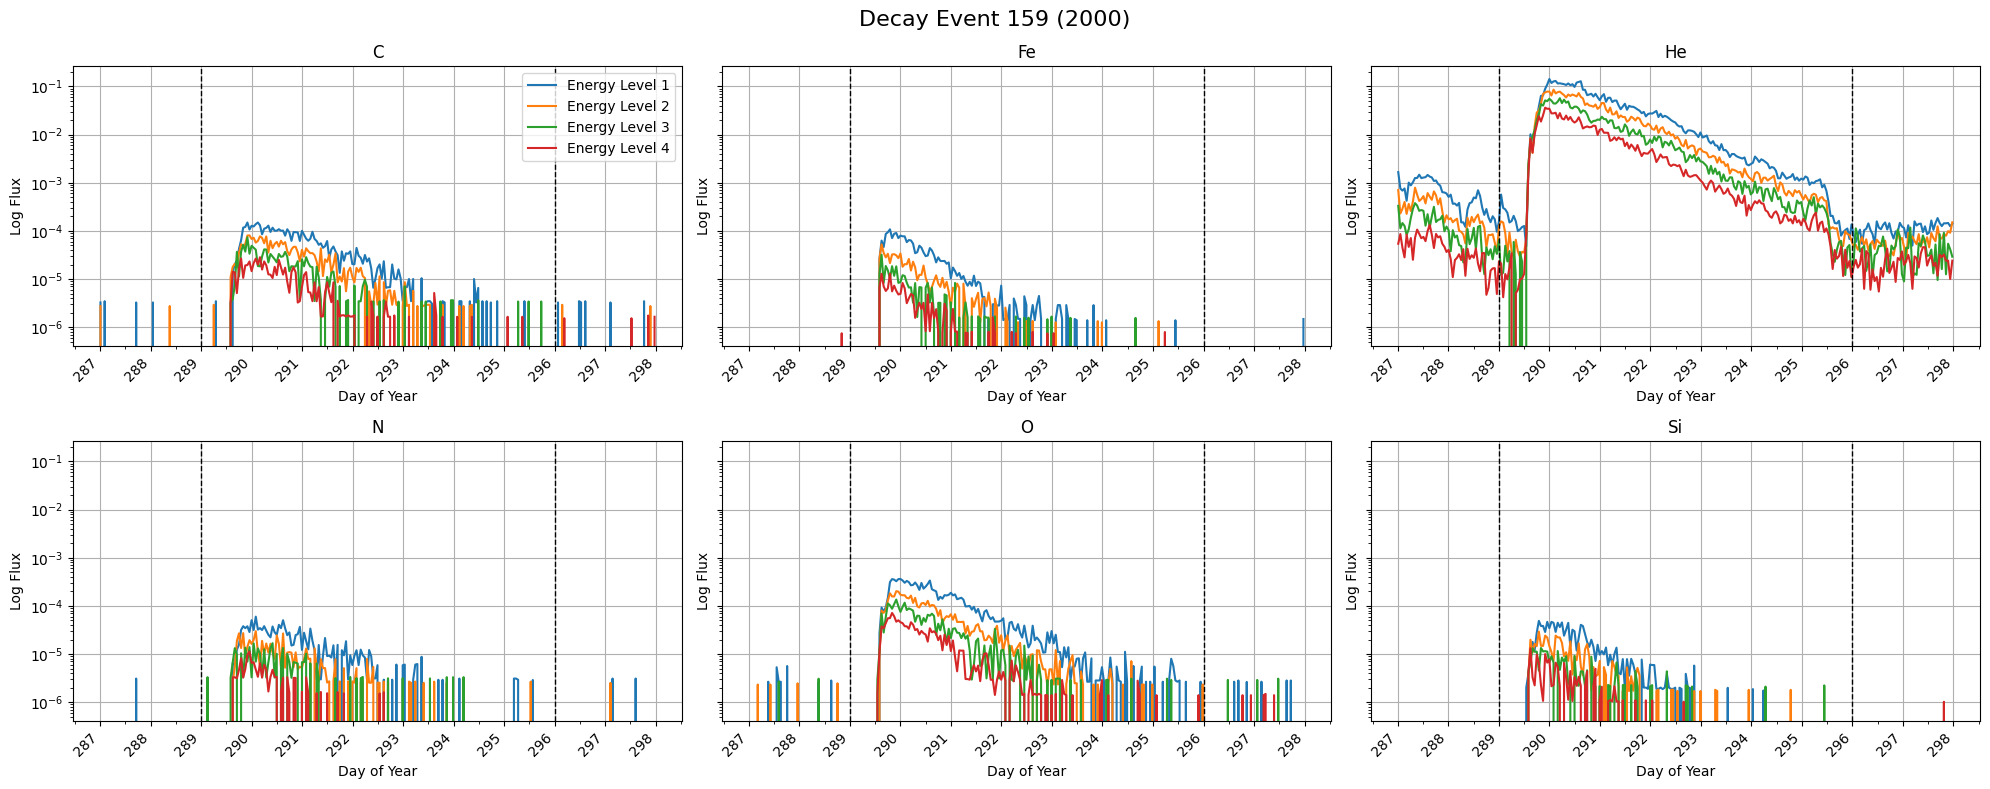

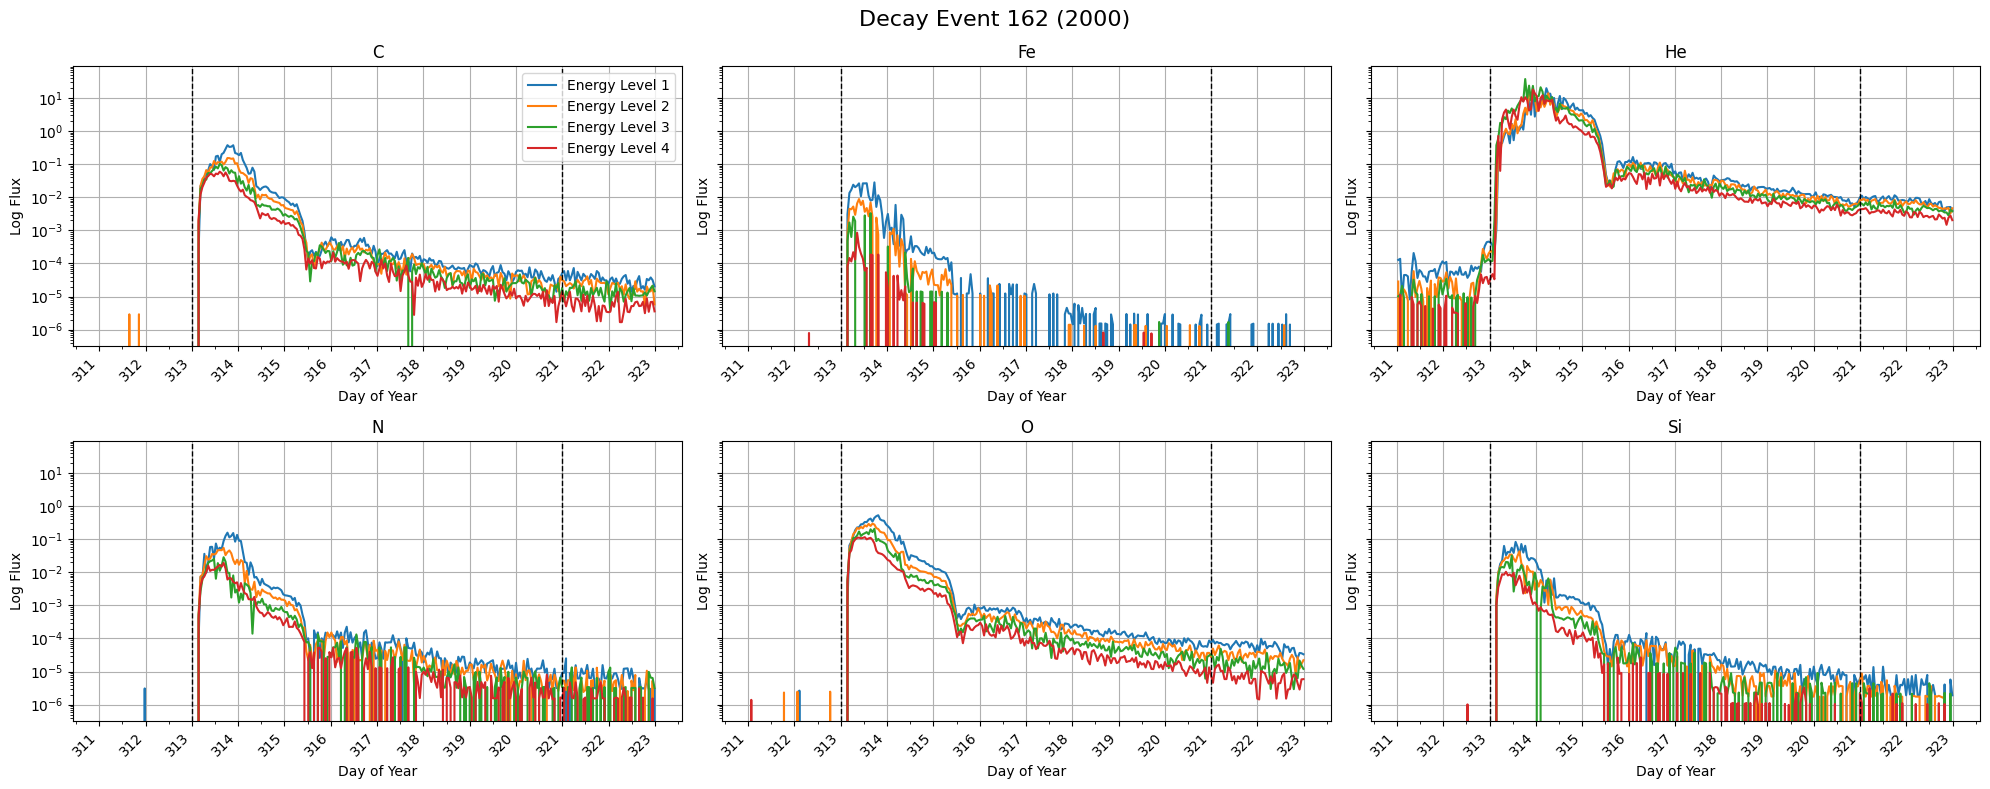

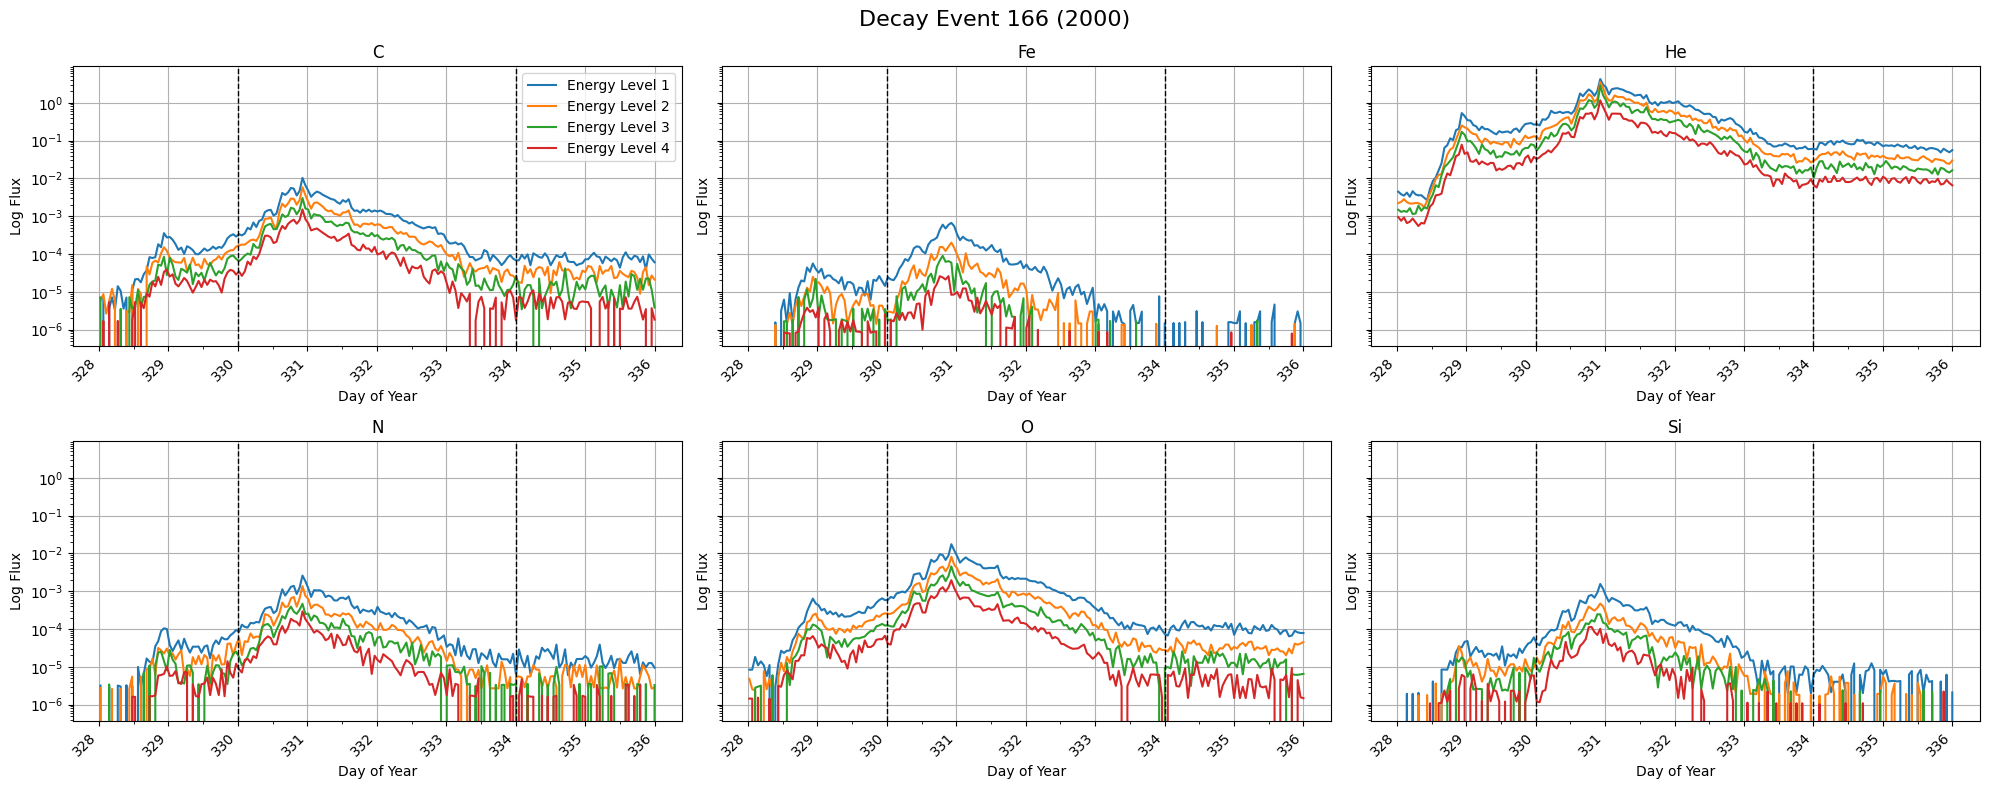

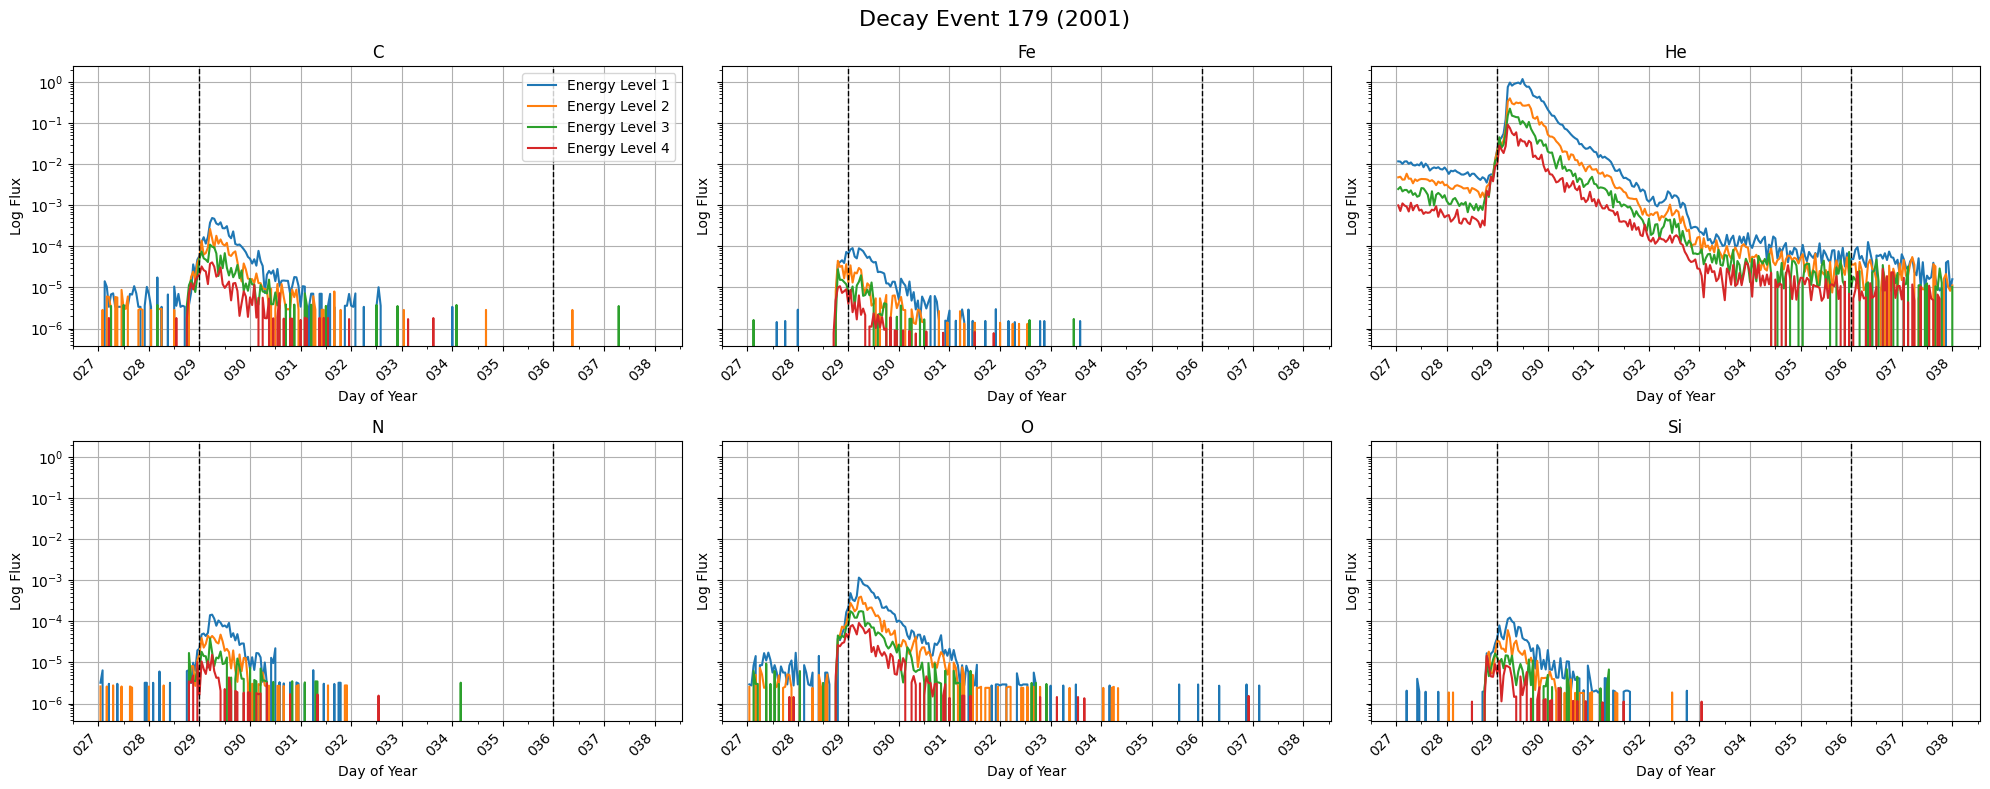

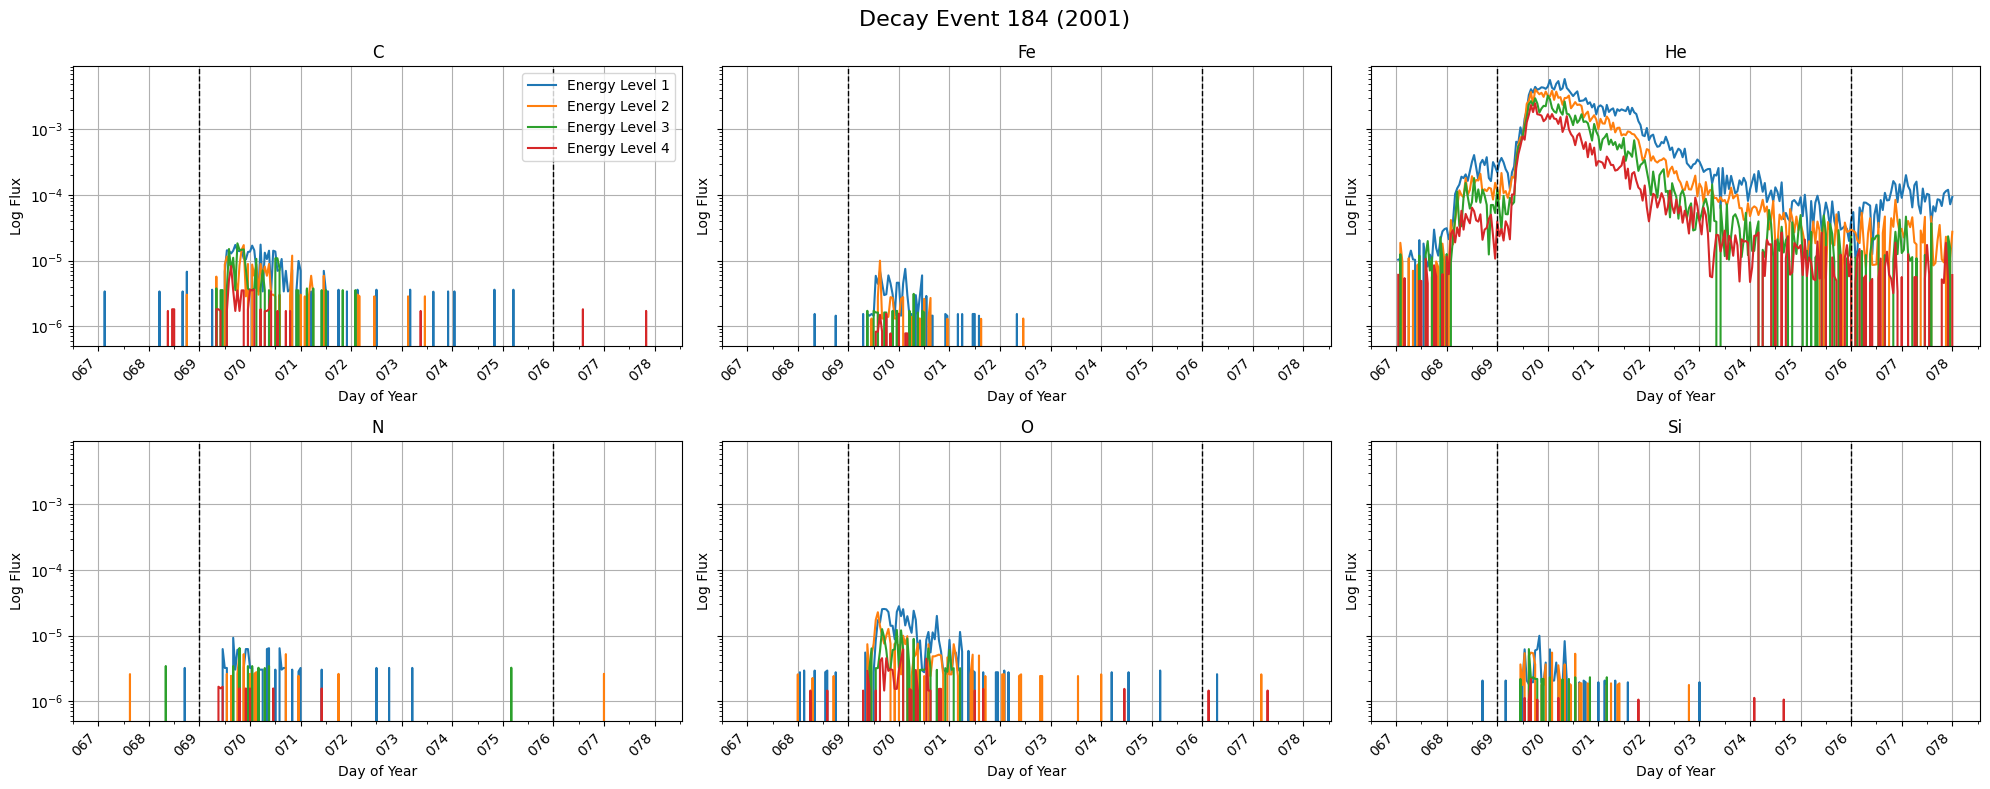

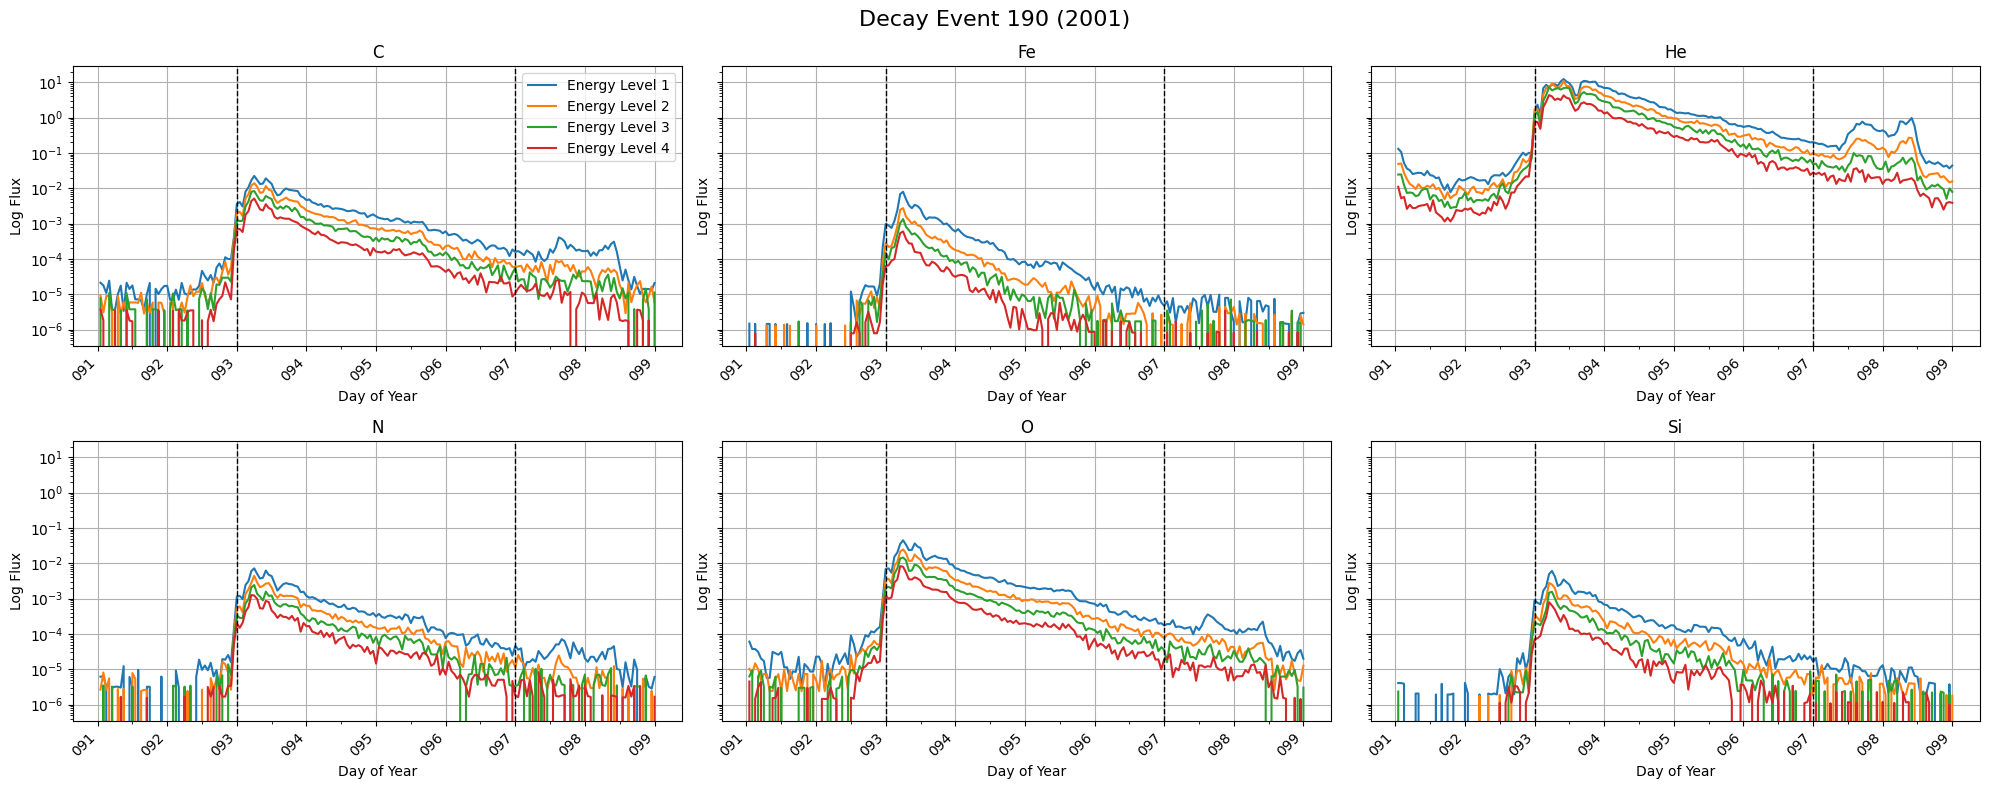

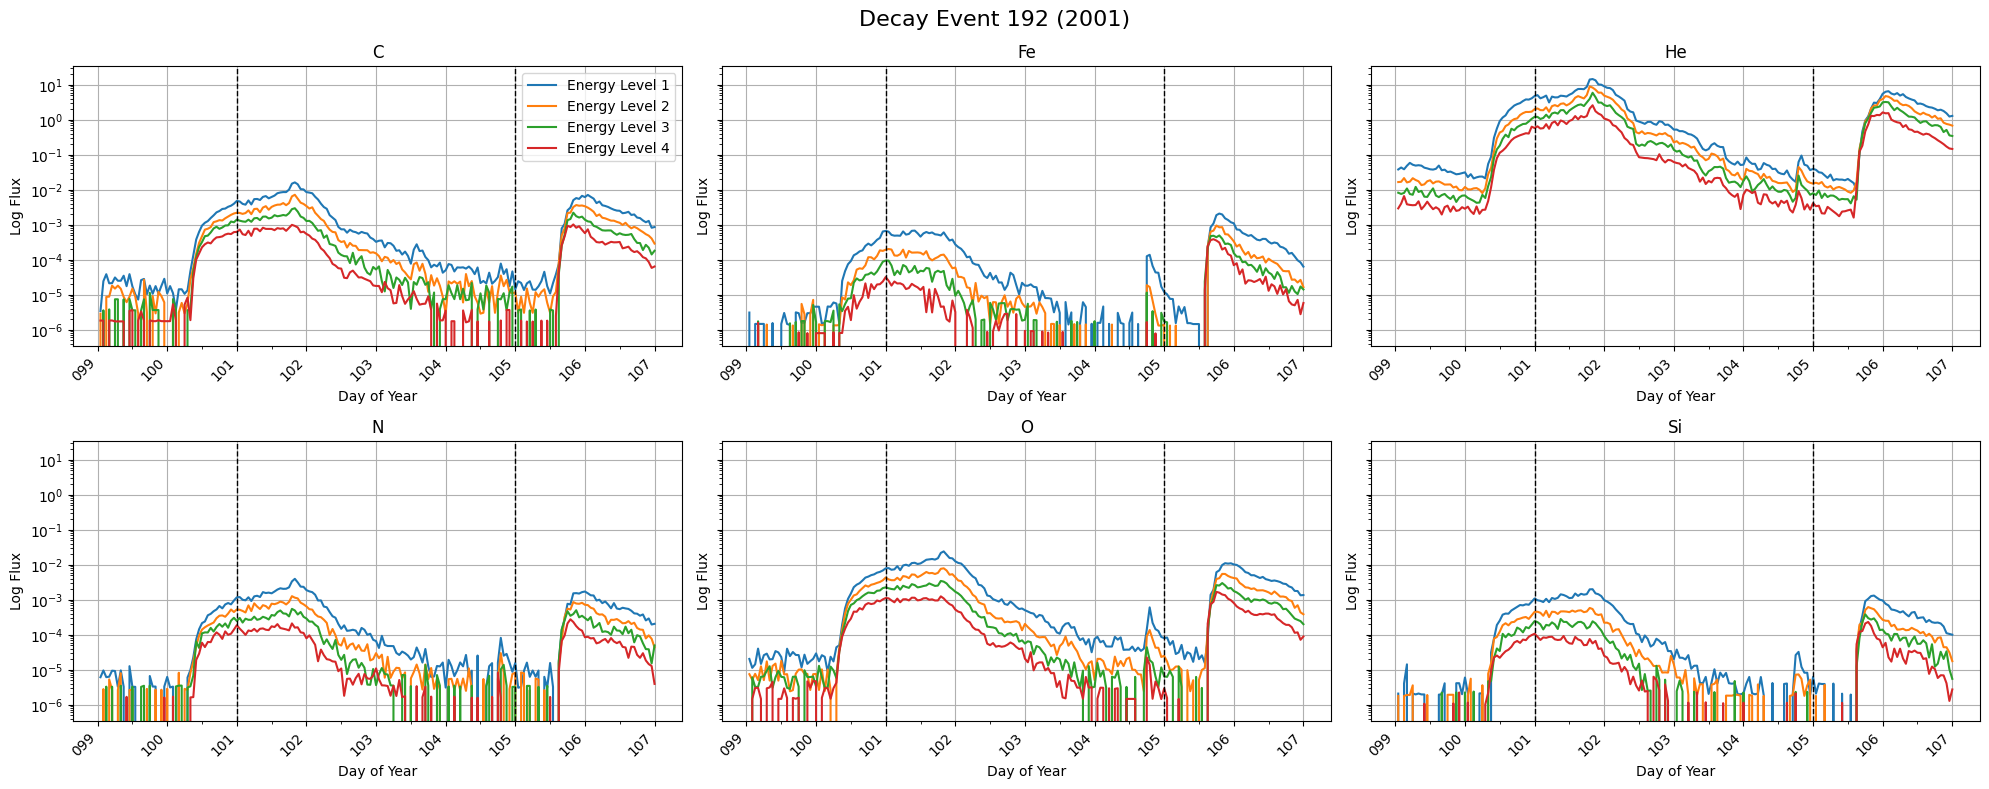

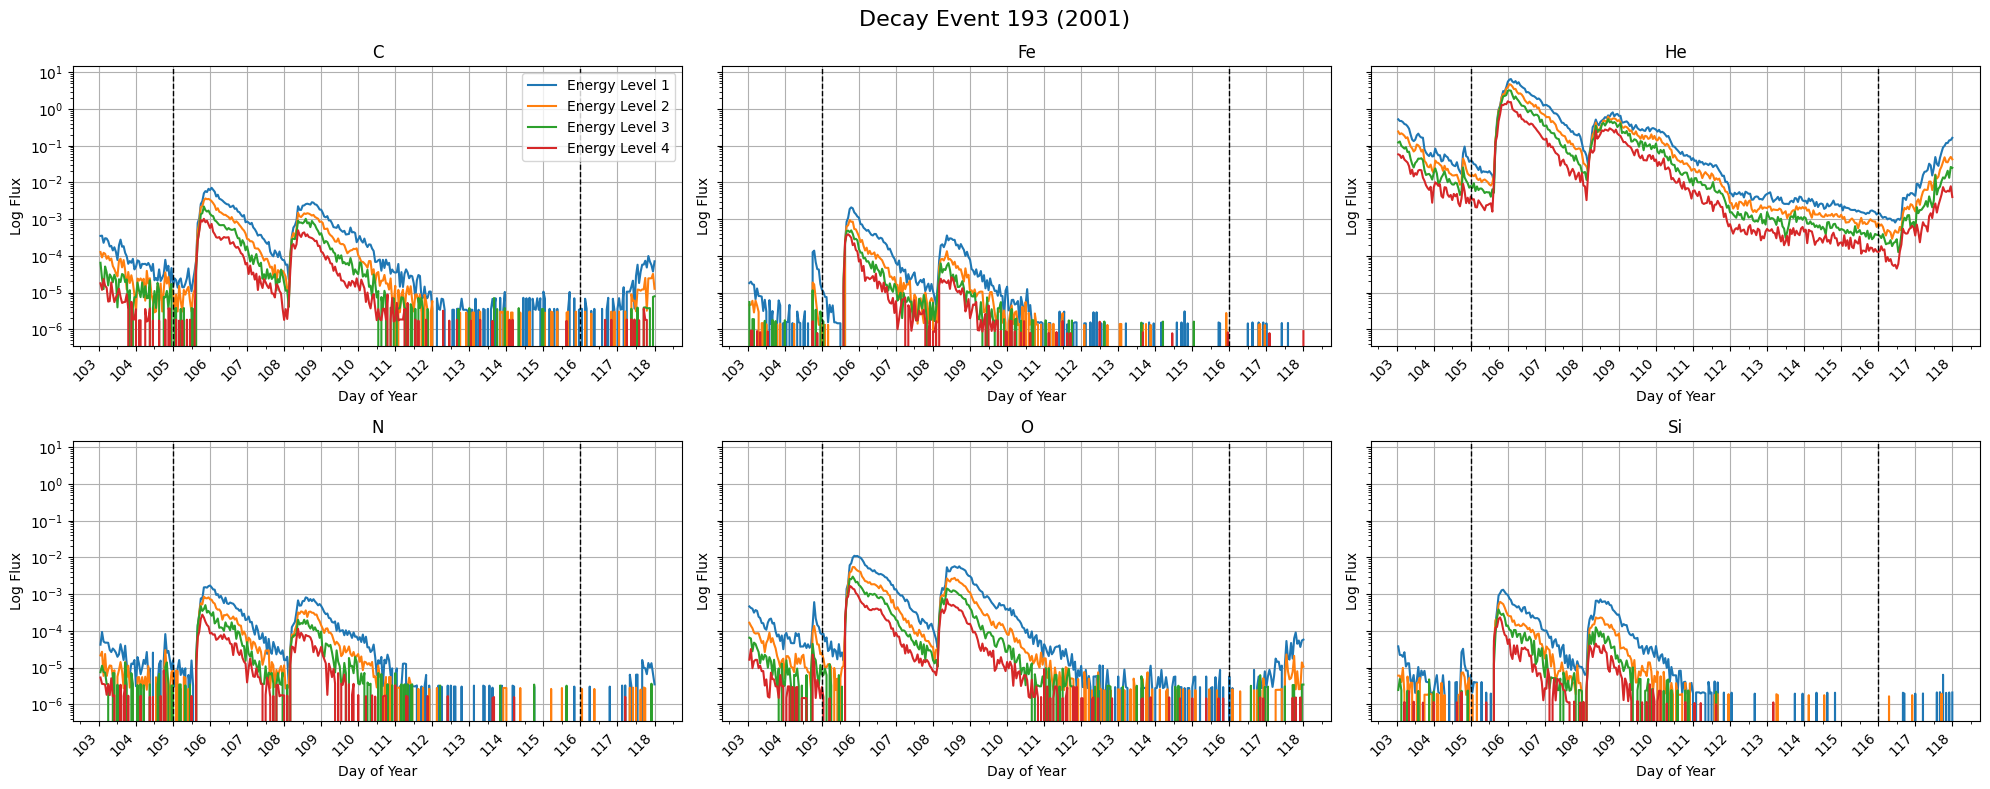

In [63]:
import pandas as pd

top_10_df = sorted_df.iloc[:20]  # Use .loc if you have custom indexing
top_10_df = top_10_df.reset_index(drop=True)

print(top_10_df)

from graph import plot_decay_events_per_element, plot_all_decay_events

# Parameters
energy_levels_to_plot = 4  # Number of lowest energy levels to plot
extend_days = 2  # Extend the time range by 2 days before and after the event
useLogScale = True  # Whether to use a logarithmic scale for the y-axis

# Plot the decay events
plot_decay_events_per_element(top_10_df, all_flux_data, datetime_values, element_mapping, energy_levels_to_plot, extend_days, useLogScale)
# plot_all_decay_events(top_10_df, all_flux_data, datetime_values, element_mapping, energy_levels_to_plot, extend_days, useLogScale)
